Starting from a 
* pre-trained model with a 
* pre-trained tokenizer

we perform finetuning on a negation task

In [208]:
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
import random
from tqdm import tqdm

from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch import device, cuda, version

import apex

import dcc_splitter as splitter
import ner_training as trainer
import pandas as pd

import seaborn
import matplotlib.pyplot as plt

from collections import namedtuple

from transformers import AutoTokenizer, RobertaTokenizer, AutoModelForTokenClassification

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [209]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [210]:
device = device("cuda:0") if cuda.is_available() else device("cpu")

In [211]:
device

device(type='cuda', index=0)

In [40]:
dcc_dir = None
output_dir = None
skip_file = None
n_splits = 10
random_state = None
base_folder = "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels"
output_folder = "fine_tuned_token_classification"
mod_name = "robbert-v2-dutch-base" # "robbert-v2-dutch-base" # belabBERT_115k # bert-base-dutch
 

args = namedtuple
args.task = "negation" # experiencer, temporality
args.model_path = os.path.join(base_folder, mod_name)
args.model_type = "roberta" # bertje
args.output_dir = os.path.join(base_folder, output_folder)
args.num_epochs = 4
args.eval_steps = 10 
args.lr = 5e-5
args.batch_size=16
args.gradient_accumulation_steps=1
args.block_size = 32
args.save_model=False
args.bio=True
args.do_eval=True
args.do_write=False
args.bootstrap=False
args.do_print_class_report=False

random.seed(77)

In [41]:
# dcc-splitter for folds
dcc_splitter = splitter.DCCSplitter(dcc_dir, output_dir, skip_file, n_splits, random_state, write_to_file=False)
splits = dcc_splitter.split()

In [42]:
# load NER DCC set
dcc = pd.read_csv("../data/RobBERT/DCC.tsv", 
                  sep="\t", 
                  skip_blank_lines=True, 
                  engine="python", 
                  encoding="utf-8",
                  on_bad_lines="warn", 
                  keep_default_na=False)

Skipping line 13610: field larger than field limit (131072)
Skipping line 20017: field larger than field limit (131072)
Skipping line 33436: field larger than field limit (131072)
Skipping line 39932: field larger than field limit (131072)
Skipping line 48840: field larger than field limit (131072)
Skipping line 67717: field larger than field limit (131072)
Skipping line 70612: field larger than field limit (131072)
Skipping line 75877: field larger than field limit (131072)
Skipping line 98174: field larger than field limit (131072)


In [291]:
Texts = dcc.groupby('Id').Word.apply(lambda x: " ".join(x))

In [43]:
dcc.loc[dcc.Id=='GP2218'][['Word', 'BIO', 'Negation', 'Experiencer', 'Temporality']].values

array([['Trombofilie', 'B', 'NotNegated', 'Patient', 'Recent'],
       ['O', 'O', 'O', 'O', 'O'],
       ['?', 'O', 'O', 'O', 'O'],
       ['ACUUT', 'O', 'O', 'O', 'O'],
       ['ANTERO', 'O', 'O', 'O', 'O'],
       ['Car', 'O', 'O', 'O', 'O'],
       ['[O]', 'O', 'O', 'O', 'O'],
       ['SEPTAAL', 'O', 'O', 'O', 'O'],
       ['-', 'O', 'O', 'O', 'O'],
       ['ANTEROLATERAAL', 'O', 'O', 'O', 'O'],
       ['INFARCT', 'B', 'NotNegated', 'Patient', 'Recent'],
       ['.', 'O', 'O', 'O', 'O'],
       ['ER', 'O', 'O', 'O', 'O'],
       ['WERD', 'O', 'O', 'O', 'O'],
       ['EEN', 'O', 'O', 'O', 'O'],
       ['STENT', 'O', 'O', 'O', 'O'],
       ['GE', 'O', 'O', 'O', 'O'],
       ['Car', 'O', 'O', 'O', 'O'],
       ['[O]', 'O', 'O', 'O', 'O'],
       ['IMPLANTEERD', 'O', 'O', 'O', 'O'],
       ['IN', 'O', 'O', 'O', 'O'],
       ['DE', 'O', 'O', 'O', 'O'],
       ['LAD', 'O', 'O', 'O', 'O'],
       ['.', 'O', 'O', 'O', 'O'],
       ['NA', 'O', 'O', 'O', 'O'],
       ['PTCA', 'O', 'O', 'O', '

In [44]:
tag_ids = {'negation':{'B-Negated':0,'B-NotNegated':1,'I-Negated':2,'I-NotNegated':3},
          'temporality':{'B-Recent':0,'B-Historical':1,'B-Hypothetical':2,'I-Recent':3,'I-Historical':4,'I-Hypothetical':5},
          'experiencer':{'B-Patient':0,'B-Other':1,'I-Patient':2,'I-Other':3}}

tag2id = tag_ids[args.task]
tokenizer = AutoTokenizer.from_pretrained(args.model_path)

## Over all document sources

improvement: only output best model based on validation scores

In [45]:
# cycle through folds
scores = []
predlist = []
test_lists = []
loss_history = {}
for idx, fold in tqdm(enumerate(splits)):
    # re-init model for each fold, otherwise it keeps on training the same throughout all folds..
    token_model = AutoModelForTokenClassification.from_pretrained(args.model_path, num_labels = len(tag2id))
    
    train_list, test_list = fold['train'], fold['test']
    
    ## eval is optional (to gauge the best number of steps/epochs)
    eval_list = random.choices(train_list,k=int(len(train_list)/10))
    eval_dcc = dcc.loc[dcc.Id.isin(eval_list)]
    test_dcc = dcc.loc[dcc.Id.isin(test_list)]
    train_dcc = dcc.loc[(dcc.Id.isin(train_list)) & (~dcc.Id.isin(eval_list))]

    ###
    train_dataset = trainer.TextDatasetFromDataFrame(train_dcc, tokenizer, args) 
    test_dataset = trainer.TextDatasetFromDataFrame(test_dcc, tokenizer, args)
    eval_dataset = trainer.TextDatasetFromDataFrame(eval_dcc, tokenizer, args)
    
    args.do_print_class_report=False
    # Train on all document sources
    trained_model, eval_loss_history = trainer.train_model(model=token_model.to(device), 
                                                            tokenizer=tokenizer, 
                                                            train_dataset=train_dataset, 
                                                            eval_dataset=eval_dataset, 
                                                            tag2id=tag2id,
                                                            device=device, 
                                                            args=args,
                                                            max_grad_norm=1.0,
                                                            amp=False)
    args.do_print_class_report=True
    # Evaluate on all document sources
    f1, prec, rec, preds, truth = trainer.eval_model(model=trained_model, 
                                       tokenizer=tokenizer, 
                                       eval_dataset=test_dataset, 
                                       tag2id=tag2id, 
                                       device=device, 
                                       args=args, 
                                       return_pred=True)
    
    loss_history[idx]=eval_loss_history
    scores.append({'fold': idx, 'f1': f1, 'precision': prec, 'recall': rec})
    predlist.append({'fold': idx, 'prediction': preds, 'truth': truth})
    test_lists.append(test_list)
    

0it [00:00, ?it/s]Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/163 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.63


Epoch 1:   1%|█▎                                                                                                      | 2/163 [00:00<01:02,  2.59it/s]

F1: 0.396 


Epoch 1:   6%|█████▋                                                                                                  | 9/163 [00:01<00:18,  8.26it/s]

Epoch 1, step 10: training loss = 0.94


Epoch 1:   8%|████████▏                                                                                              | 13/163 [00:02<00:25,  5.91it/s]

F1: 0.725 


Epoch 1:  12%|████████████▋                                                                                          | 20/163 [00:03<00:15,  9.25it/s]

Epoch 1, step 20: training loss = 0.85


Epoch 1:  14%|██████████████▌                                                                                        | 23/163 [00:03<00:23,  5.84it/s]

F1: 0.731 


Epoch 1:  18%|██████████████████▎                                                                                    | 29/163 [00:04<00:15,  8.80it/s]

Epoch 1, step 30: training loss = 0.76


Epoch 1:  20%|████████████████████▊                                                                                  | 33/163 [00:05<00:20,  6.31it/s]

F1: 0.779 


Epoch 1:  25%|█████████████████████████▎                                                                             | 40/163 [00:06<00:14,  8.58it/s]

Epoch 1, step 40: training loss = 0.68


Epoch 1:  26%|███████████████████████████▏                                                                           | 43/163 [00:06<00:21,  5.62it/s]

F1: 0.857 


Epoch 1:  31%|███████████████████████████████▌                                                                       | 50/163 [00:07<00:12,  9.26it/s]

Epoch 1, step 50: training loss = 0.60


Epoch 1:  32%|████████████████████████████████▊                                                                      | 52/163 [00:08<00:20,  5.44it/s]

F1: 0.862 


Epoch 1:  37%|█████████████████████████████████████▉                                                                 | 60/163 [00:09<00:12,  8.44it/s]

Epoch 1, step 60: training loss = 0.56


Epoch 1:  39%|███████████████████████████████████████▊                                                               | 63/163 [00:09<00:18,  5.46it/s]

F1: 0.946 


Epoch 1:  43%|████████████████████████████████████████████▏                                                          | 70/163 [00:10<00:10,  8.83it/s]

Epoch 1, step 70: training loss = 0.53


Epoch 1:  44%|█████████████████████████████████████████████▍                                                         | 72/163 [00:11<00:18,  4.98it/s]

F1: 0.903 


Epoch 1:  49%|██████████████████████████████████████████████████▌                                                    | 80/163 [00:12<00:09,  9.05it/s]

Epoch 1, step 80: training loss = 0.52


Epoch 1:  50%|███████████████████████████████████████████████████▊                                                   | 82/163 [00:12<00:15,  5.26it/s]

F1: 0.942 


Epoch 1:  55%|████████████████████████████████████████████████████████▊                                              | 90/163 [00:13<00:08,  8.66it/s]

Epoch 1, step 90: training loss = 0.49


Epoch 1:  57%|██████████████████████████████████████████████████████████▊                                            | 93/163 [00:14<00:13,  5.21it/s]

F1: 0.909 


Epoch 1:  61%|██████████████████████████████████████████████████████████████▌                                        | 99/163 [00:15<00:07,  8.38it/s]

Epoch 1, step 100: training loss = 0.48


Epoch 1:  63%|████████████████████████████████████████████████████████████████▍                                     | 103/163 [00:15<00:09,  6.14it/s]

F1: 0.942 


Epoch 1:  67%|████████████████████████████████████████████████████████████████████▊                                 | 110/163 [00:16<00:05,  9.07it/s]

Epoch 1, step 110: training loss = 0.46


Epoch 1:  69%|██████████████████████████████████████████████████████████████████████                                | 112/163 [00:17<00:09,  5.29it/s]

F1: 0.929 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████                           | 120/163 [00:18<00:04,  8.63it/s]

Epoch 1, step 120: training loss = 0.45


Epoch 1:  75%|████████████████████████████████████████████████████████████████████████████▎                         | 122/163 [00:18<00:07,  5.19it/s]

F1: 0.921 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 130/163 [00:19<00:03,  8.65it/s]

Epoch 1, step 130: training loss = 0.43


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 132/163 [00:20<00:07,  4.31it/s]

F1: 0.926 


Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 140/163 [00:21<00:02,  8.60it/s]

Epoch 1, step 140: training loss = 0.42


Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 143/163 [00:22<00:04,  4.98it/s]

F1: 0.939 


Epoch 1:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 149/163 [00:22<00:01,  8.36it/s]

Epoch 1, step 150: training loss = 0.41


Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 153/163 [00:23<00:01,  6.24it/s]

F1: 0.927 


Epoch 1:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 159/163 [00:24<00:00,  8.88it/s]

Epoch 1, step 160: training loss = 0.40


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:25<00:00,  6.52it/s]


F1: 0.933 


Epoch 2:   4%|███▊                                                                                                    | 6/163 [00:00<00:14, 11.09it/s]

Epoch 2, step 170: training loss = 0.20


Epoch 2:   6%|██████▎                                                                                                | 10/163 [00:01<00:23,  6.46it/s]

F1: 0.923 


Epoch 2:  10%|██████████                                                                                             | 16/163 [00:02<00:16,  8.75it/s]

Epoch 2, step 180: training loss = 0.20


Epoch 2:  12%|████████████▋                                                                                          | 20/163 [00:02<00:24,  5.96it/s]

F1: 0.959 


Epoch 2:  16%|████████████████▍                                                                                      | 26/163 [00:03<00:16,  8.55it/s]

Epoch 2, step 190: training loss = 0.20


Epoch 2:  18%|██████████████████▉                                                                                    | 30/163 [00:04<00:21,  6.21it/s]

F1: 0.967 


Epoch 2:  22%|██████████████████████▋                                                                                | 36/163 [00:04<00:14,  8.69it/s]

Epoch 2, step 200: training loss = 0.19


Epoch 2:  25%|█████████████████████████▎                                                                             | 40/163 [00:05<00:19,  6.42it/s]

F1: 0.958 


Epoch 2:  28%|█████████████████████████████                                                                          | 46/163 [00:06<00:13,  8.92it/s]

Epoch 2, step 210: training loss = 0.19


Epoch 2:  31%|███████████████████████████████▌                                                                       | 50/163 [00:07<00:17,  6.49it/s]

F1: 0.964 


Epoch 2:  34%|███████████████████████████████████▍                                                                   | 56/163 [00:07<00:12,  8.87it/s]

Epoch 2, step 220: training loss = 0.19


Epoch 2:  37%|█████████████████████████████████████▉                                                                 | 60/163 [00:08<00:15,  6.46it/s]

F1: 0.970 


Epoch 2:  41%|██████████████████████████████████████████▎                                                            | 67/163 [00:09<00:10,  9.20it/s]

Epoch 2, step 230: training loss = 0.18


Epoch 2:  42%|███████████████████████████████████████████▌                                                           | 69/163 [00:09<00:17,  5.49it/s]

F1: 0.973 


Epoch 2:  47%|████████████████████████████████████████████████▋                                                      | 77/163 [00:10<00:09,  9.06it/s]

Epoch 2, step 240: training loss = 0.18


Epoch 2:  48%|█████████████████████████████████████████████████▉                                                     | 79/163 [00:11<00:15,  5.58it/s]

F1: 0.972 


Epoch 2:  53%|██████████████████████████████████████████████████████▉                                                | 87/163 [00:12<00:08,  9.18it/s]

Epoch 2, step 250: training loss = 0.18


Epoch 2:  55%|████████████████████████████████████████████████████████▏                                              | 89/163 [00:12<00:13,  5.47it/s]

F1: 0.958 


Epoch 2:  60%|█████████████████████████████████████████████████████████████▎                                         | 97/163 [00:13<00:07,  9.09it/s]

Epoch 2, step 260: training loss = 0.18


Epoch 2:  61%|██████████████████████████████████████████████████████████████▌                                        | 99/163 [00:14<00:11,  5.68it/s]

F1: 0.962 


Epoch 2:  66%|██████████████████████████████████████████████████████████████████▉                                   | 107/163 [00:14<00:06,  9.26it/s]

Epoch 2, step 270: training loss = 0.18


Epoch 2:  67%|████████████████████████████████████████████████████████████████████▏                                 | 109/163 [00:15<00:09,  5.66it/s]

F1: 0.967 


Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████▏                            | 117/163 [00:16<00:04,  9.32it/s]

Epoch 2, step 280: training loss = 0.18


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▍                           | 119/163 [00:16<00:07,  5.69it/s]

F1: 0.967 


Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████▍                      | 127/163 [00:17<00:03,  9.22it/s]

Epoch 2, step 290: training loss = 0.17


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████▋                     | 129/163 [00:18<00:05,  5.68it/s]

F1: 0.959 


Epoch 2:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 137/163 [00:18<00:02,  9.22it/s]

Epoch 2, step 300: training loss = 0.17


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 139/163 [00:19<00:04,  5.67it/s]

F1: 0.950 


Epoch 2:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 147/163 [00:20<00:01,  9.14it/s]

Epoch 2, step 310: training loss = 0.17


Epoch 2:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 149/163 [00:20<00:02,  5.65it/s]

F1: 0.959 


Epoch 2:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 157/163 [00:21<00:00,  9.13it/s]

Epoch 2, step 320: training loss = 0.17


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 159/163 [00:22<00:00,  5.66it/s]

F1: 0.965 


Epoch 3:   2%|██▌                                                                                                     | 4/163 [00:00<00:14, 11.31it/s]

Epoch 3, step 330: training loss = 0.12


Epoch 3:   4%|███▊                                                                                                    | 6/163 [00:01<00:31,  4.94it/s]

F1: 0.970 


Epoch 3:   9%|████████▊                                                                                              | 14/163 [00:01<00:16,  9.29it/s]

Epoch 3, step 340: training loss = 0.08


Epoch 3:  10%|██████████                                                                                             | 16/163 [00:02<00:26,  5.58it/s]

F1: 0.962 


Epoch 3:  15%|███████████████▏                                                                                       | 24/163 [00:03<00:15,  9.20it/s]

Epoch 3, step 350: training loss = 0.07


Epoch 3:  16%|████████████████▍                                                                                      | 26/163 [00:03<00:24,  5.69it/s]

F1: 0.962 


Epoch 3:  21%|█████████████████████▍                                                                                 | 34/163 [00:04<00:13,  9.35it/s]

Epoch 3, step 360: training loss = 0.06


Epoch 3:  22%|██████████████████████▋                                                                                | 36/163 [00:05<00:22,  5.70it/s]

F1: 0.957 


Epoch 3:  27%|███████████████████████████▊                                                                           | 44/163 [00:05<00:12,  9.25it/s]

Epoch 3, step 370: training loss = 0.09


Epoch 3:  28%|█████████████████████████████                                                                          | 46/163 [00:06<00:20,  5.66it/s]

F1: 0.958 


Epoch 3:  33%|██████████████████████████████████                                                                     | 54/163 [00:07<00:11,  9.26it/s]

Epoch 3, step 380: training loss = 0.08


Epoch 3:  34%|███████████████████████████████████▍                                                                   | 56/163 [00:07<00:18,  5.70it/s]

F1: 0.951 


Epoch 3:  39%|████████████████████████████████████████▍                                                              | 64/163 [00:08<00:10,  9.29it/s]

Epoch 3, step 390: training loss = 0.08


Epoch 3:  40%|█████████████████████████████████████████▋                                                             | 66/163 [00:09<00:17,  5.68it/s]

F1: 0.951 


Epoch 3:  45%|██████████████████████████████████████████████▊                                                        | 74/163 [00:09<00:09,  9.22it/s]

Epoch 3, step 400: training loss = 0.08


Epoch 3:  47%|████████████████████████████████████████████████                                                       | 76/163 [00:10<00:15,  5.69it/s]

F1: 0.951 


Epoch 3:  52%|█████████████████████████████████████████████████████                                                  | 84/163 [00:11<00:08,  8.97it/s]

Epoch 3, step 410: training loss = 0.08


Epoch 3:  53%|██████████████████████████████████████████████████████▎                                                | 86/163 [00:11<00:14,  5.40it/s]

F1: 0.956 


Epoch 3:  58%|███████████████████████████████████████████████████████████▍                                           | 94/163 [00:12<00:07,  9.01it/s]

Epoch 3, step 420: training loss = 0.08


Epoch 3:  59%|████████████████████████████████████████████████████████████▋                                          | 96/163 [00:13<00:12,  5.48it/s]

F1: 0.956 


Epoch 3:  64%|█████████████████████████████████████████████████████████████████                                     | 104/163 [00:14<00:06,  9.01it/s]

Epoch 3, step 430: training loss = 0.08


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▎                                   | 106/163 [00:14<00:10,  5.58it/s]

F1: 0.964 


Epoch 3:  70%|███████████████████████████████████████████████████████████████████████▎                              | 114/163 [00:15<00:05,  9.13it/s]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  71%|████████████████████████████████████████████████████████████████████████▌                             | 116/163 [00:16<00:08,  5.64it/s]

F1: 0.962 


Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████▌                        | 124/163 [00:16<00:04,  8.87it/s]

Epoch 3, step 450: training loss = 0.08


Epoch 3:  77%|██████████████████████████████████████████████████████████████████████████████▊                       | 126/163 [00:17<00:06,  5.55it/s]

F1: 0.962 


Epoch 3:  82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 134/163 [00:18<00:03,  9.10it/s]

Epoch 3, step 460: training loss = 0.08


Epoch 3:  83%|█████████████████████████████████████████████████████████████████████████████████████                 | 136/163 [00:18<00:04,  5.68it/s]

F1: 0.967 


Epoch 3:  88%|██████████████████████████████████████████████████████████████████████████████████████████            | 144/163 [00:19<00:02,  9.29it/s]

Epoch 3, step 470: training loss = 0.08


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 147/163 [00:20<00:02,  6.08it/s]

F1: 0.967 


Epoch 3:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 153/163 [00:20<00:01,  9.15it/s]

Epoch 3, step 480: training loss = 0.09


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 157/163 [00:21<00:00,  6.42it/s]

F1: 0.959 


Epoch 4:   0%|                                                                                                                | 0/163 [00:00<?, ?it/s]

Epoch 4, step 490: training loss = 0.03


Epoch 4:   2%|██▌                                                                                                     | 4/163 [00:00<00:30,  5.24it/s]

F1: 0.956 


Epoch 4:   6%|██████▎                                                                                                | 10/163 [00:01<00:16,  9.21it/s]

Epoch 4, step 500: training loss = 0.03


Epoch 4:   9%|████████▊                                                                                              | 14/163 [00:02<00:22,  6.55it/s]

F1: 0.962 


Epoch 4:  12%|████████████▋                                                                                          | 20/163 [00:02<00:15,  9.19it/s]

Epoch 4, step 510: training loss = 0.04


Epoch 4:  14%|██████████████▌                                                                                        | 23/163 [00:03<00:24,  5.82it/s]

F1: 0.959 


Epoch 4:  18%|██████████████████▉                                                                                    | 30/163 [00:04<00:14,  9.21it/s]

Epoch 4, step 520: training loss = 0.04


Epoch 4:  21%|█████████████████████▍                                                                                 | 34/163 [00:05<00:20,  6.35it/s]

F1: 0.969 


Epoch 4:  25%|█████████████████████████▎                                                                             | 40/163 [00:05<00:13,  9.21it/s]

Epoch 4, step 530: training loss = 0.05


Epoch 4:  27%|███████████████████████████▊                                                                           | 44/163 [00:06<00:17,  6.67it/s]

F1: 0.969 


Epoch 4:  31%|███████████████████████████████▌                                                                       | 50/163 [00:06<00:12,  9.21it/s]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  33%|██████████████████████████████████                                                                     | 54/163 [00:07<00:16,  6.68it/s]

F1: 0.969 


Epoch 4:  37%|█████████████████████████████████████▉                                                                 | 60/163 [00:08<00:11,  9.30it/s]

Epoch 4, step 550: training loss = 0.05


Epoch 4:  39%|████████████████████████████████████████▍                                                              | 64/163 [00:09<00:14,  6.67it/s]

F1: 0.965 


Epoch 4:  43%|████████████████████████████████████████████▏                                                          | 70/163 [00:09<00:09,  9.31it/s]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  45%|██████████████████████████████████████████████▊                                                        | 74/163 [00:10<00:13,  6.70it/s]

F1: 0.956 


Epoch 4:  49%|██████████████████████████████████████████████████▌                                                    | 80/163 [00:11<00:09,  9.19it/s]

Epoch 4, step 570: training loss = 0.06


Epoch 4:  52%|█████████████████████████████████████████████████████                                                  | 84/163 [00:11<00:11,  6.68it/s]

F1: 0.956 


Epoch 4:  55%|████████████████████████████████████████████████████████▊                                              | 90/163 [00:12<00:07,  9.31it/s]

Epoch 4, step 580: training loss = 0.06


Epoch 4:  58%|███████████████████████████████████████████████████████████▍                                           | 94/163 [00:13<00:10,  6.71it/s]

F1: 0.956 


Epoch 4:  61%|██████████████████████████████████████████████████████████████▌                                       | 100/163 [00:13<00:06,  9.21it/s]

Epoch 4, step 590: training loss = 0.06


Epoch 4:  64%|█████████████████████████████████████████████████████████████████                                     | 104/163 [00:14<00:08,  6.69it/s]

F1: 0.961 


Epoch 4:  67%|████████████████████████████████████████████████████████████████████▊                                 | 110/163 [00:15<00:05,  9.28it/s]

Epoch 4, step 600: training loss = 0.05


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▎                              | 114/163 [00:16<00:07,  6.68it/s]

F1: 0.964 


Epoch 4:  74%|███████████████████████████████████████████████████████████████████████████                           | 120/163 [00:16<00:04,  8.68it/s]

Epoch 4, step 610: training loss = 0.05


Epoch 4:  76%|█████████████████████████████████████████████████████████████████████████████▌                        | 124/163 [00:17<00:06,  6.05it/s]

F1: 0.964 


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 130/163 [00:18<00:03,  9.04it/s]

Epoch 4, step 620: training loss = 0.05


Epoch 4:  82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 134/163 [00:18<00:04,  6.60it/s]

F1: 0.964 


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 140/163 [00:19<00:02,  9.26it/s]

Epoch 4, step 630: training loss = 0.05


Epoch 4:  88%|██████████████████████████████████████████████████████████████████████████████████████████            | 144/163 [00:20<00:02,  6.67it/s]

F1: 0.964 


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 150/163 [00:20<00:01,  9.34it/s]

Epoch 4, step 640: training loss = 0.05


Epoch 4:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 154/163 [00:21<00:01,  6.76it/s]

F1: 0.964 


Epoch 4:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 160/163 [00:22<00:00,  9.26it/s]

Epoch 4, step 650: training loss = 0.05


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:22<00:00,  7.14it/s]

F1: 0.964 
Training finished, best model f = 0.973



1it [01:51, 111.88s/it]

F1: 0.929 
              precision    recall  f1-score   support

     Negated       0.84      0.90      0.87        52
  NotNegated       0.92      0.95      0.94       377

   micro avg       0.91      0.95      0.93       429
   macro avg       0.88      0.93      0.90       429
weighted avg       0.91      0.95      0.93       429



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.24


Epoch 1:   2%|█▉                                                                                                      | 3/162 [00:00<00:35,  4.47it/s]

F1: 0.689 


Epoch 1:   6%|█████▊                                                                                                  | 9/162 [00:01<00:16,  9.05it/s]

Epoch 1, step 10: training loss = 0.83


Epoch 1:   8%|████████▎                                                                                              | 13/162 [00:02<00:23,  6.41it/s]

F1: 0.702 


Epoch 1:  12%|████████████                                                                                           | 19/162 [00:02<00:15,  9.10it/s]

Epoch 1, step 20: training loss = 0.79


Epoch 1:  14%|██████████████▌                                                                                        | 23/162 [00:03<00:21,  6.59it/s]

F1: 0.767 


Epoch 1:  18%|██████████████████▍                                                                                    | 29/162 [00:04<00:14,  9.22it/s]

Epoch 1, step 30: training loss = 0.71


Epoch 1:  20%|████████████████████▉                                                                                  | 33/162 [00:04<00:19,  6.62it/s]

F1: 0.794 


Epoch 1:  24%|████████████████████████▊                                                                              | 39/162 [00:05<00:13,  9.10it/s]

Epoch 1, step 40: training loss = 0.65


Epoch 1:  27%|███████████████████████████▎                                                                           | 43/162 [00:06<00:18,  6.58it/s]

F1: 0.825 


Epoch 1:  30%|███████████████████████████████▏                                                                       | 49/162 [00:06<00:12,  9.09it/s]

Epoch 1, step 50: training loss = 0.59


Epoch 1:  33%|█████████████████████████████████▋                                                                     | 53/162 [00:07<00:16,  6.61it/s]

F1: 0.817 


Epoch 1:  36%|█████████████████████████████████████▌                                                                 | 59/162 [00:08<00:11,  9.19it/s]

Epoch 1, step 60: training loss = 0.56


Epoch 1:  39%|████████████████████████████████████████                                                               | 63/162 [00:09<00:15,  6.58it/s]

F1: 0.862 


Epoch 1:  43%|███████████████████████████████████████████▊                                                           | 69/162 [00:09<00:10,  9.13it/s]

Epoch 1, step 70: training loss = 0.53


Epoch 1:  45%|██████████████████████████████████████████████▍                                                        | 73/162 [00:10<00:13,  6.57it/s]

F1: 0.876 


Epoch 1:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [00:10<00:09,  9.17it/s]

Epoch 1, step 80: training loss = 0.51


Epoch 1:  51%|████████████████████████████████████████████████████▊                                                  | 83/162 [00:11<00:11,  6.63it/s]

F1: 0.889 


Epoch 1:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [00:12<00:08,  9.11it/s]

Epoch 1, step 90: training loss = 0.49


Epoch 1:  57%|███████████████████████████████████████████████████████████▏                                           | 93/162 [00:13<00:10,  6.64it/s]

F1: 0.868 


Epoch 1:  62%|██████████████████████████████████████████████████████████████▉                                       | 100/162 [00:13<00:06,  8.87it/s]

Epoch 1, step 100: training loss = 0.46


Epoch 1:  64%|████████████████████████████████████████████████████████████████▊                                     | 103/162 [00:14<00:10,  5.66it/s]

F1: 0.887 


Epoch 1:  67%|████████████████████████████████████████████████████████████████████▋                                 | 109/162 [00:15<00:05,  9.01it/s]

Epoch 1, step 110: training loss = 0.45


Epoch 1:  70%|███████████████████████████████████████████████████████████████████████▏                              | 113/162 [00:16<00:07,  6.48it/s]

F1: 0.899 


Epoch 1:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [00:16<00:04,  9.04it/s]

Epoch 1, step 120: training loss = 0.43


Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████▍                        | 123/162 [00:17<00:05,  6.62it/s]

F1: 0.896 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 129/162 [00:17<00:03,  9.14it/s]

Epoch 1, step 130: training loss = 0.42


Epoch 1:  82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 133/162 [00:18<00:04,  6.58it/s]

F1: 0.912 


Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 139/162 [00:19<00:02,  9.13it/s]

Epoch 1, step 140: training loss = 0.42


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████            | 143/162 [00:20<00:02,  6.57it/s]

F1: 0.913 


Epoch 1:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 149/162 [00:20<00:01,  9.05it/s]

Epoch 1, step 150: training loss = 0.41


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 153/162 [00:21<00:01,  6.55it/s]

F1: 0.916 


Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 159/162 [00:22<00:00,  8.82it/s]

Epoch 1, step 160: training loss = 0.40


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:22<00:00,  7.05it/s]


F1: 0.891 


Epoch 2:   5%|█████▏                                                                                                  | 8/162 [00:00<00:13, 11.39it/s]

Epoch 2, step 170: training loss = 0.15


Epoch 2:   6%|██████▎                                                                                                | 10/162 [00:01<00:27,  5.54it/s]

F1: 0.904 


Epoch 2:  11%|███████████▍                                                                                           | 18/162 [00:02<00:15,  9.39it/s]

Epoch 2, step 180: training loss = 0.15


Epoch 2:  12%|████████████▋                                                                                          | 20/162 [00:02<00:25,  5.59it/s]

F1: 0.904 


Epoch 2:  17%|█████████████████▊                                                                                     | 28/162 [00:03<00:14,  9.24it/s]

Epoch 2, step 190: training loss = 0.17


Epoch 2:  19%|███████████████████                                                                                    | 30/162 [00:04<00:23,  5.64it/s]

F1: 0.899 


Epoch 2:  23%|████████████████████████▏                                                                              | 38/162 [00:04<00:13,  9.19it/s]

Epoch 2, step 200: training loss = 0.16


Epoch 2:  25%|█████████████████████████▍                                                                             | 40/162 [00:05<00:21,  5.58it/s]

F1: 0.906 


Epoch 2:  30%|██████████████████████████████▌                                                                        | 48/162 [00:06<00:12,  9.23it/s]

Epoch 2, step 210: training loss = 0.16


Epoch 2:  31%|███████████████████████████████▊                                                                       | 50/162 [00:06<00:19,  5.64it/s]

F1: 0.902 


Epoch 2:  36%|████████████████████████████████████▉                                                                  | 58/162 [00:07<00:11,  9.05it/s]

Epoch 2, step 220: training loss = 0.17


Epoch 2:  37%|██████████████████████████████████████▏                                                                | 60/162 [00:08<00:18,  5.56it/s]

F1: 0.904 


Epoch 2:  42%|███████████████████████████████████████████▏                                                           | 68/162 [00:08<00:10,  9.14it/s]

Epoch 2, step 230: training loss = 0.18


Epoch 2:  43%|████████████████████████████████████████████▌                                                          | 70/162 [00:09<00:16,  5.58it/s]

F1: 0.922 


Epoch 2:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [00:10<00:09,  9.13it/s]

Epoch 2, step 240: training loss = 0.17


Epoch 2:  49%|██████████████████████████████████████████████████▊                                                    | 80/162 [00:11<00:14,  5.63it/s]

F1: 0.909 


Epoch 2:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [00:11<00:08,  9.15it/s]

Epoch 2, step 250: training loss = 0.16


Epoch 2:  56%|█████████████████████████████████████████████████████████▏                                             | 90/162 [00:12<00:12,  5.60it/s]

F1: 0.907 


Epoch 2:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [00:13<00:07,  9.08it/s]

Epoch 2, step 260: training loss = 0.16


Epoch 2:  62%|██████████████████████████████████████████████████████████████▉                                       | 100/162 [00:13<00:11,  5.56it/s]

F1: 0.908 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [00:14<00:05,  9.12it/s]

Epoch 2, step 270: training loss = 0.16


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████▎                                | 110/162 [00:15<00:09,  5.61it/s]

F1: 0.920 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [00:15<00:04,  9.13it/s]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  74%|███████████████████████████████████████████████████████████████████████████▌                          | 120/162 [00:16<00:07,  5.60it/s]

F1: 0.919 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [00:17<00:03,  9.09it/s]

Epoch 2, step 290: training loss = 0.15


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 130/162 [00:17<00:05,  5.56it/s]

F1: 0.909 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [00:18<00:02,  9.12it/s]

Epoch 2, step 300: training loss = 0.16


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 140/162 [00:19<00:03,  5.54it/s]

F1: 0.906 


Epoch 2:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [00:20<00:01,  9.10it/s]

Epoch 2, step 310: training loss = 0.15


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 150/162 [00:20<00:02,  5.59it/s]

F1: 0.913 


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [00:21<00:00,  9.14it/s]

Epoch 2, step 320: training loss = 0.16


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 161/162 [00:22<00:00,  6.02it/s]

F1: 0.913 


Epoch 3:   4%|███▊                                                                                                    | 6/162 [00:00<00:16,  9.48it/s]

Epoch 3, step 330: training loss = 0.08


Epoch 3:   6%|█████▊                                                                                                  | 9/162 [00:01<00:28,  5.41it/s]

F1: 0.911 


Epoch 3:   9%|█████████▌                                                                                             | 15/162 [00:01<00:16,  8.99it/s]

Epoch 3, step 340: training loss = 0.06


Epoch 3:  12%|████████████                                                                                           | 19/162 [00:02<00:22,  6.47it/s]

F1: 0.911 


Epoch 3:  15%|███████████████▉                                                                                       | 25/162 [00:03<00:14,  9.20it/s]

Epoch 3, step 350: training loss = 0.05


Epoch 3:  18%|██████████████████▍                                                                                    | 29/162 [00:04<00:20,  6.56it/s]

F1: 0.911 


Epoch 3:  22%|██████████████████████▎                                                                                | 35/162 [00:04<00:13,  9.15it/s]

Epoch 3, step 360: training loss = 0.05


Epoch 3:  24%|████████████████████████▊                                                                              | 39/162 [00:05<00:18,  6.64it/s]

F1: 0.915 


Epoch 3:  28%|████████████████████████████▌                                                                          | 45/162 [00:06<00:12,  9.09it/s]

Epoch 3, step 370: training loss = 0.05


Epoch 3:  30%|███████████████████████████████▏                                                                       | 49/162 [00:06<00:17,  6.60it/s]

F1: 0.921 


Epoch 3:  34%|██████████████████████████████████▉                                                                    | 55/162 [00:07<00:11,  9.14it/s]

Epoch 3, step 380: training loss = 0.06


Epoch 3:  36%|█████████████████████████████████████▌                                                                 | 59/162 [00:08<00:15,  6.55it/s]

F1: 0.918 


Epoch 3:  40%|█████████████████████████████████████████▎                                                             | 65/162 [00:08<00:10,  9.14it/s]

Epoch 3, step 390: training loss = 0.07


Epoch 3:  43%|███████████████████████████████████████████▊                                                           | 69/162 [00:09<00:14,  6.46it/s]

F1: 0.911 


Epoch 3:  46%|███████████████████████████████████████████████▋                                                       | 75/162 [00:10<00:09,  8.91it/s]

Epoch 3, step 400: training loss = 0.07


Epoch 3:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [00:11<00:12,  6.56it/s]

F1: 0.911 


Epoch 3:  52%|██████████████████████████████████████████████████████                                                 | 85/162 [00:11<00:08,  9.14it/s]

Epoch 3, step 410: training loss = 0.07


Epoch 3:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [00:12<00:11,  6.47it/s]

F1: 0.910 


Epoch 3:  59%|████████████████████████████████████████████████████████████▍                                          | 95/162 [00:13<00:07,  9.09it/s]

Epoch 3, step 420: training loss = 0.07


Epoch 3:  61%|██████████████████████████████████████████████████████████████▉                                        | 99/162 [00:13<00:09,  6.65it/s]

F1: 0.910 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [00:14<00:05,  9.72it/s]

Epoch 3, step 430: training loss = 0.08


Epoch 3:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [00:15<00:09,  5.62it/s]

F1: 0.913 


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [00:15<00:04,  9.21it/s]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [00:16<00:07,  5.58it/s]

F1: 0.914 


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [00:17<00:03,  9.17it/s]

Epoch 3, step 450: training loss = 0.07


Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [00:17<00:06,  5.60it/s]

F1: 0.914 


Epoch 3:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [00:18<00:02,  9.14it/s]

Epoch 3, step 460: training loss = 0.07


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [00:19<00:04,  5.63it/s]

F1: 0.917 


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [00:20<00:01,  9.14it/s]

Epoch 3, step 470: training loss = 0.07


Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [00:20<00:02,  5.59it/s]

F1: 0.911 


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [00:21<00:00,  9.13it/s]

Epoch 3, step 480: training loss = 0.08


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [00:22<00:00,  5.60it/s]

F1: 0.911 


Epoch 4:   2%|██▌                                                                                                     | 4/162 [00:00<00:13, 11.43it/s]

Epoch 4, step 490: training loss = 0.03


Epoch 4:   4%|███▊                                                                                                    | 6/162 [00:01<00:31,  4.91it/s]

F1: 0.914 


Epoch 4:   9%|████████▉                                                                                              | 14/162 [00:01<00:15,  9.39it/s]

Epoch 4, step 500: training loss = 0.02


Epoch 4:  10%|██████████▏                                                                                            | 16/162 [00:02<00:26,  5.53it/s]

F1: 0.920 


Epoch 4:  15%|███████████████▎                                                                                       | 24/162 [00:03<00:14,  9.21it/s]

Epoch 4, step 510: training loss = 0.02


Epoch 4:  16%|████████████████▌                                                                                      | 26/162 [00:03<00:24,  5.59it/s]

F1: 0.921 


Epoch 4:  21%|█████████████████████▌                                                                                 | 34/162 [00:04<00:13,  9.17it/s]

Epoch 4, step 520: training loss = 0.02


Epoch 4:  22%|██████████████████████▉                                                                                | 36/162 [00:05<00:22,  5.59it/s]

F1: 0.913 


Epoch 4:  27%|███████████████████████████▉                                                                           | 44/162 [00:05<00:12,  9.23it/s]

Epoch 4, step 530: training loss = 0.03


Epoch 4:  28%|█████████████████████████████▏                                                                         | 46/162 [00:06<00:20,  5.63it/s]

F1: 0.913 


Epoch 4:  33%|██████████████████████████████████▎                                                                    | 54/162 [00:07<00:11,  9.31it/s]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  35%|███████████████████████████████████▌                                                                   | 56/162 [00:07<00:18,  5.59it/s]

F1: 0.917 


Epoch 4:  40%|████████████████████████████████████████▋                                                              | 64/162 [00:08<00:10,  9.15it/s]

Epoch 4, step 550: training loss = 0.04


Epoch 4:  41%|█████████████████████████████████████████▉                                                             | 66/162 [00:09<00:17,  5.60it/s]

F1: 0.913 


Epoch 4:  46%|███████████████████████████████████████████████                                                        | 74/162 [00:09<00:09,  9.19it/s]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [00:10<00:15,  5.61it/s]

F1: 0.921 


Epoch 4:  52%|█████████████████████████████████████████████████████▍                                                 | 84/162 [00:11<00:08,  9.30it/s]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [00:12<00:14,  5.27it/s]

F1: 0.921 


Epoch 4:  58%|███████████████████████████████████████████████████████████▊                                           | 94/162 [00:12<00:07,  8.90it/s]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [00:13<00:11,  5.56it/s]

F1: 0.917 


Epoch 4:  64%|█████████████████████████████████████████████████████████████████▍                                    | 104/162 [00:14<00:06,  9.14it/s]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [00:14<00:10,  5.59it/s]

F1: 0.921 


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▊                              | 114/162 [00:15<00:05,  9.24it/s]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [00:16<00:08,  5.61it/s]

F1: 0.917 


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████                        | 124/162 [00:16<00:04,  9.30it/s]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [00:17<00:06,  5.64it/s]

F1: 0.921 


Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 134/162 [00:18<00:03,  9.19it/s]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [00:18<00:04,  5.61it/s]

F1: 0.921 


Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 144/162 [00:19<00:02,  8.93it/s]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [00:20<00:03,  5.26it/s]

F1: 0.917 


Epoch 4:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 154/162 [00:21<00:00,  9.09it/s]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [00:21<00:01,  5.56it/s]

F1: 0.921 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:22<00:00,  7.27it/s]


Training finished, best model f = 0.922


2it [03:39, 109.41s/it]

F1: 0.929 
              precision    recall  f1-score   support

     Negated       0.95      0.90      0.93        42
  NotNegated       0.91      0.94      0.93       376

   micro avg       0.92      0.94      0.93       418
   macro avg       0.93      0.92      0.93       418
weighted avg       0.92      0.94      0.93       418



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.35


Epoch 1:   2%|█▉                                                                                                      | 3/161 [00:00<00:36,  4.36it/s]

F1: 0.725 


Epoch 1:   6%|█████▊                                                                                                  | 9/161 [00:01<00:17,  8.87it/s]

Epoch 1, step 10: training loss = 0.80


Epoch 1:   8%|████████▎                                                                                              | 13/161 [00:02<00:23,  6.21it/s]

F1: 0.737 


Epoch 1:  12%|████████████▏                                                                                          | 19/161 [00:02<00:15,  9.08it/s]

Epoch 1, step 20: training loss = 0.79


Epoch 1:  14%|██████████████▋                                                                                        | 23/161 [00:03<00:21,  6.40it/s]

F1: 0.743 


Epoch 1:  18%|██████████████████▌                                                                                    | 29/161 [00:04<00:14,  9.05it/s]

Epoch 1, step 30: training loss = 0.75


Epoch 1:  20%|█████████████████████                                                                                  | 33/161 [00:05<00:19,  6.42it/s]

F1: 0.788 


Epoch 1:  24%|████████████████████████▉                                                                              | 39/161 [00:05<00:13,  9.07it/s]

Epoch 1, step 40: training loss = 0.69


Epoch 1:  27%|███████████████████████████▌                                                                           | 43/161 [00:06<00:18,  6.42it/s]

F1: 0.840 


Epoch 1:  30%|███████████████████████████████▎                                                                       | 49/161 [00:06<00:12,  9.04it/s]

Epoch 1, step 50: training loss = 0.62


Epoch 1:  33%|█████████████████████████████████▉                                                                     | 53/161 [00:07<00:16,  6.41it/s]

F1: 0.841 


Epoch 1:  37%|█████████████████████████████████████▋                                                                 | 59/161 [00:08<00:11,  8.99it/s]

Epoch 1, step 60: training loss = 0.58


Epoch 1:  39%|████████████████████████████████████████▎                                                              | 63/161 [00:09<00:15,  6.39it/s]

F1: 0.886 


Epoch 1:  43%|████████████████████████████████████████████▏                                                          | 69/161 [00:09<00:10,  8.89it/s]

Epoch 1, step 70: training loss = 0.55


Epoch 1:  45%|██████████████████████████████████████████████▋                                                        | 73/161 [00:10<00:13,  6.38it/s]

F1: 0.862 


Epoch 1:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [00:11<00:09,  8.62it/s]

Epoch 1, step 80: training loss = 0.52


Epoch 1:  52%|█████████████████████████████████████████████████████                                                  | 83/161 [00:12<00:13,  5.85it/s]

F1: 0.920 


Epoch 1:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [00:12<00:08,  8.87it/s]

Epoch 1, step 90: training loss = 0.50


Epoch 1:  58%|███████████████████████████████████████████████████████████▍                                           | 93/161 [00:13<00:10,  6.29it/s]

F1: 0.889 


Epoch 1:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [00:14<00:06,  8.99it/s]

Epoch 1, step 100: training loss = 0.48


Epoch 1:  64%|█████████████████████████████████████████████████████████████████▎                                    | 103/161 [00:15<00:09,  6.39it/s]

F1: 0.922 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [00:15<00:05,  8.94it/s]

Epoch 1, step 110: training loss = 0.46


Epoch 1:  70%|███████████████████████████████████████████████████████████████████████▌                              | 113/161 [00:16<00:07,  6.42it/s]

F1: 0.904 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [00:17<00:04,  9.01it/s]

Epoch 1, step 120: training loss = 0.45


Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████▉                        | 123/161 [00:17<00:05,  6.39it/s]

F1: 0.919 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [00:18<00:03,  9.01it/s]

Epoch 1, step 130: training loss = 0.44


Epoch 1:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 133/161 [00:19<00:04,  6.42it/s]

F1: 0.907 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [00:19<00:02,  9.02it/s]

Epoch 1, step 140: training loss = 0.43


Epoch 1:  89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 143/161 [00:20<00:02,  6.45it/s]

F1: 0.930 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [00:21<00:01,  8.93it/s]

Epoch 1, step 150: training loss = 0.42


Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 153/161 [00:22<00:01,  6.36it/s]

F1: 0.915 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [00:22<00:00,  8.93it/s]

Epoch 1, step 160: training loss = 0.41


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:23<00:00,  6.88it/s]


F1: 0.938 


Epoch 2:   5%|█████▏                                                                                                  | 8/161 [00:00<00:13, 11.37it/s]

Epoch 2, step 170: training loss = 0.21


Epoch 2:   7%|███████▋                                                                                               | 12/161 [00:01<00:22,  6.62it/s]

F1: 0.935 


Epoch 2:  11%|███████████▌                                                                                           | 18/161 [00:02<00:15,  9.24it/s]

Epoch 2, step 180: training loss = 0.15


Epoch 2:  14%|██████████████                                                                                         | 22/161 [00:03<00:21,  6.43it/s]

F1: 0.937 


Epoch 2:  17%|█████████████████▉                                                                                     | 28/161 [00:03<00:14,  9.06it/s]

Epoch 2, step 190: training loss = 0.14


Epoch 2:  20%|████████████████████▍                                                                                  | 32/161 [00:04<00:20,  6.43it/s]

F1: 0.934 


Epoch 2:  24%|████████████████████████▎                                                                              | 38/161 [00:04<00:13,  9.04it/s]

Epoch 2, step 200: training loss = 0.15


Epoch 2:  26%|██████████████████████████▊                                                                            | 42/161 [00:05<00:18,  6.42it/s]

F1: 0.922 


Epoch 2:  30%|██████████████████████████████▋                                                                        | 48/161 [00:06<00:12,  9.06it/s]

Epoch 2, step 210: training loss = 0.16


Epoch 2:  32%|█████████████████████████████████▎                                                                     | 52/161 [00:07<00:16,  6.46it/s]

F1: 0.921 


Epoch 2:  36%|█████████████████████████████████████                                                                  | 58/161 [00:07<00:11,  9.01it/s]

Epoch 2, step 220: training loss = 0.16


Epoch 2:  39%|███████████████████████████████████████▋                                                               | 62/161 [00:08<00:15,  6.45it/s]

F1: 0.907 


Epoch 2:  42%|███████████████████████████████████████████▌                                                           | 68/161 [00:09<00:10,  9.04it/s]

Epoch 2, step 230: training loss = 0.17


Epoch 2:  45%|██████████████████████████████████████████████                                                         | 72/161 [00:10<00:13,  6.45it/s]

F1: 0.927 


Epoch 2:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [00:10<00:09,  8.99it/s]

Epoch 2, step 240: training loss = 0.17


Epoch 2:  51%|████████████████████████████████████████████████████▍                                                  | 82/161 [00:11<00:12,  6.46it/s]

F1: 0.922 


Epoch 2:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [00:12<00:08,  9.06it/s]

Epoch 2, step 250: training loss = 0.16


Epoch 2:  57%|██████████████████████████████████████████████████████████▊                                            | 92/161 [00:12<00:10,  6.39it/s]

F1: 0.917 


Epoch 2:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [00:13<00:06,  9.07it/s]

Epoch 2, step 260: training loss = 0.17


Epoch 2:  63%|████████████████████████████████████████████████████████████████▌                                     | 102/161 [00:14<00:09,  6.46it/s]

F1: 0.924 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [00:14<00:05,  8.99it/s]

Epoch 2, step 270: training loss = 0.17


Epoch 2:  70%|██████████████████████████████████████████████████████████████████████▉                               | 112/161 [00:15<00:07,  6.39it/s]

F1: 0.926 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [00:16<00:04,  8.92it/s]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  76%|█████████████████████████████████████████████████████████████████████████████▎                        | 122/161 [00:17<00:06,  6.35it/s]

F1: 0.928 


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [00:17<00:03,  8.99it/s]

Epoch 2, step 290: training loss = 0.17


Epoch 2:  82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 132/161 [00:18<00:04,  6.46it/s]

F1: 0.934 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [00:19<00:02,  9.23it/s]

Epoch 2, step 300: training loss = 0.17


Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 141/161 [00:19<00:03,  5.36it/s]

F1: 0.913 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [00:20<00:01,  9.04it/s]

Epoch 2, step 310: training loss = 0.17


Epoch 2:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 151/161 [00:21<00:01,  5.40it/s]

F1: 0.926 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [00:22<00:00,  8.95it/s]

Epoch 2, step 320: training loss = 0.17


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.07it/s]


F1: 0.928 


Epoch 3:   5%|█████▏                                                                                                  | 8/161 [00:00<00:13, 11.36it/s]

Epoch 3, step 330: training loss = 0.10


Epoch 3:   6%|██████▍                                                                                                | 10/161 [00:01<00:28,  5.39it/s]

F1: 0.930 


Epoch 3:  11%|███████████▌                                                                                           | 18/161 [00:02<00:15,  9.19it/s]

Epoch 3, step 340: training loss = 0.08


Epoch 3:  12%|████████████▊                                                                                          | 20/161 [00:02<00:26,  5.42it/s]

F1: 0.926 


Epoch 3:  17%|█████████████████▉                                                                                     | 28/161 [00:03<00:14,  9.13it/s]

Epoch 3, step 350: training loss = 0.08


Epoch 3:  19%|███████████████████▏                                                                                   | 30/161 [00:04<00:24,  5.43it/s]

F1: 0.942 


Epoch 3:  24%|████████████████████████▎                                                                              | 38/161 [00:04<00:13,  9.02it/s]

Epoch 3, step 360: training loss = 0.08


Epoch 3:  25%|█████████████████████████▌                                                                             | 40/161 [00:05<00:22,  5.41it/s]

F1: 0.939 


Epoch 3:  30%|██████████████████████████████▋                                                                        | 48/161 [00:06<00:12,  8.96it/s]

Epoch 3, step 370: training loss = 0.09


Epoch 3:  31%|███████████████████████████████▉                                                                       | 50/161 [00:07<00:20,  5.37it/s]

F1: 0.938 


Epoch 3:  36%|█████████████████████████████████████                                                                  | 58/161 [00:07<00:11,  9.12it/s]

Epoch 3, step 380: training loss = 0.08


Epoch 3:  37%|██████████████████████████████████████▍                                                                | 60/161 [00:08<00:18,  5.43it/s]

F1: 0.945 


Epoch 3:  42%|███████████████████████████████████████████▌                                                           | 68/161 [00:09<00:10,  9.04it/s]

Epoch 3, step 390: training loss = 0.08


Epoch 3:  43%|████████████████████████████████████████████▊                                                          | 70/161 [00:09<00:16,  5.43it/s]

F1: 0.941 


Epoch 3:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [00:10<00:09,  9.05it/s]

Epoch 3, step 400: training loss = 0.08


Epoch 3:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [00:11<00:14,  5.43it/s]

F1: 0.945 


Epoch 3:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [00:12<00:08,  9.08it/s]

Epoch 3, step 410: training loss = 0.09


Epoch 3:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [00:12<00:13,  5.42it/s]

F1: 0.940 


Epoch 3:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [00:13<00:06,  9.09it/s]

Epoch 3, step 420: training loss = 0.09


Epoch 3:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [00:14<00:11,  5.46it/s]

F1: 0.938 


Epoch 3:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [00:14<00:05,  9.03it/s]

Epoch 3, step 430: training loss = 0.09


Epoch 3:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [00:15<00:09,  5.40it/s]

F1: 0.946 


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [00:16<00:04,  9.05it/s]

Epoch 3, step 440: training loss = 0.09


Epoch 3:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [00:16<00:07,  5.40it/s]

F1: 0.945 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [00:17<00:03,  9.03it/s]

Epoch 3, step 450: training loss = 0.09


Epoch 3:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [00:18<00:05,  5.44it/s]

F1: 0.945 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [00:19<00:02,  9.03it/s]

Epoch 3, step 460: training loss = 0.09


Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [00:19<00:03,  5.43it/s]

F1: 0.948 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [00:20<00:01,  8.99it/s]

Epoch 3, step 470: training loss = 0.09


Epoch 3:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [00:21<00:02,  5.40it/s]

F1: 0.948 


Epoch 3:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [00:21<00:00,  9.04it/s]

Epoch 3, step 480: training loss = 0.09


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.09it/s]


F1: 0.941 


Epoch 4:   4%|███▉                                                                                                    | 6/161 [00:00<00:13, 11.44it/s]

Epoch 4, step 490: training loss = 0.04


Epoch 4:   6%|██████▍                                                                                                | 10/161 [00:01<00:23,  6.40it/s]

F1: 0.947 


Epoch 4:  10%|██████████▏                                                                                            | 16/161 [00:01<00:15,  9.38it/s]

Epoch 4, step 500: training loss = 0.05


Epoch 4:  12%|████████████▊                                                                                          | 20/161 [00:02<00:21,  6.46it/s]

F1: 0.945 


Epoch 4:  16%|████████████████▋                                                                                      | 26/161 [00:03<00:14,  9.07it/s]

Epoch 4, step 510: training loss = 0.04


Epoch 4:  19%|███████████████████▏                                                                                   | 30/161 [00:04<00:20,  6.44it/s]

F1: 0.949 


Epoch 4:  22%|███████████████████████                                                                                | 36/161 [00:04<00:13,  9.08it/s]

Epoch 4, step 520: training loss = 0.04


Epoch 4:  25%|█████████████████████████▌                                                                             | 40/161 [00:05<00:18,  6.51it/s]

F1: 0.952 


Epoch 4:  29%|█████████████████████████████▍                                                                         | 46/161 [00:06<00:12,  9.12it/s]

Epoch 4, step 530: training loss = 0.03


Epoch 4:  31%|███████████████████████████████▉                                                                       | 50/161 [00:07<00:17,  6.46it/s]

F1: 0.949 


Epoch 4:  35%|███████████████████████████████████▊                                                                   | 56/161 [00:07<00:11,  8.98it/s]

Epoch 4, step 540: training loss = 0.03


Epoch 4:  37%|██████████████████████████████████████▍                                                                | 60/161 [00:08<00:15,  6.44it/s]

F1: 0.952 


Epoch 4:  42%|██████████████████████████████████████████▊                                                            | 67/161 [00:09<00:10,  8.70it/s]

Epoch 4, step 550: training loss = 0.03


Epoch 4:  43%|████████████████████████████████████████████▊                                                          | 70/161 [00:09<00:15,  5.71it/s]

F1: 0.949 


Epoch 4:  47%|████████████████████████████████████████████████▌                                                      | 76/161 [00:10<00:09,  8.80it/s]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [00:11<00:12,  6.32it/s]

F1: 0.946 


Epoch 4:  53%|███████████████████████████████████████████████████████                                                | 86/161 [00:11<00:08,  9.10it/s]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [00:12<00:10,  6.46it/s]

F1: 0.949 


Epoch 4:  60%|█████████████████████████████████████████████████████████████▍                                         | 96/161 [00:13<00:07,  8.98it/s]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [00:14<00:09,  6.33it/s]

F1: 0.946 


Epoch 4:  66%|███████████████████████████████████████████████████████████████████▏                                  | 106/161 [00:14<00:06,  9.00it/s]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [00:15<00:07,  6.43it/s]

F1: 0.952 


Epoch 4:  72%|█████████████████████████████████████████████████████████████████████████▍                            | 116/161 [00:16<00:05,  8.99it/s]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [00:17<00:06,  6.38it/s]

F1: 0.952 


Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████▊                      | 126/161 [00:17<00:03,  9.02it/s]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [00:18<00:04,  6.44it/s]

F1: 0.952 


Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 136/161 [00:18<00:02,  9.05it/s]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [00:19<00:03,  6.39it/s]

F1: 0.954 


Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 146/161 [00:20<00:01,  9.00it/s]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [00:21<00:01,  6.46it/s]

F1: 0.954 


Epoch 4:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 156/161 [00:21<00:00,  9.11it/s]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [00:22<00:00,  6.42it/s]

F1: 0.952 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.06it/s]


Training finished, best model f = 0.954


3it [05:28, 109.30s/it]

F1: 0.952 
              precision    recall  f1-score   support

     Negated       0.91      0.91      0.91        65
  NotNegated       0.95      0.97      0.96       384

   micro avg       0.94      0.96      0.95       449
   macro avg       0.93      0.94      0.93       449
weighted avg       0.94      0.96      0.95       449



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.63


Epoch 1:   2%|█▉                                                                                                      | 3/162 [00:00<00:36,  4.42it/s]

F1: 0.517 


Epoch 1:   6%|█████▊                                                                                                  | 9/162 [00:01<00:17,  8.88it/s]

Epoch 1, step 10: training loss = 0.96


Epoch 1:   8%|████████▎                                                                                              | 13/162 [00:02<00:24,  6.04it/s]

F1: 0.713 


Epoch 1:  12%|████████████                                                                                           | 19/162 [00:02<00:16,  8.82it/s]

Epoch 1, step 20: training loss = 0.83


Epoch 1:  14%|██████████████▌                                                                                        | 23/162 [00:03<00:21,  6.40it/s]

F1: 0.713 


Epoch 1:  18%|██████████████████▍                                                                                    | 29/162 [00:04<00:14,  8.96it/s]

Epoch 1, step 30: training loss = 0.74


Epoch 1:  20%|████████████████████▉                                                                                  | 33/162 [00:05<00:19,  6.48it/s]

F1: 0.814 


Epoch 1:  24%|████████████████████████▊                                                                              | 39/162 [00:05<00:13,  9.09it/s]

Epoch 1, step 40: training loss = 0.67


Epoch 1:  27%|███████████████████████████▎                                                                           | 43/162 [00:06<00:18,  6.51it/s]

F1: 0.862 


Epoch 1:  30%|███████████████████████████████▏                                                                       | 49/162 [00:06<00:12,  9.10it/s]

Epoch 1, step 50: training loss = 0.62


Epoch 1:  33%|█████████████████████████████████▋                                                                     | 53/162 [00:07<00:16,  6.50it/s]

F1: 0.821 


Epoch 1:  36%|█████████████████████████████████████▌                                                                 | 59/162 [00:08<00:11,  9.09it/s]

Epoch 1, step 60: training loss = 0.57


Epoch 1:  39%|████████████████████████████████████████                                                               | 63/162 [00:09<00:15,  6.50it/s]

F1: 0.885 


Epoch 1:  43%|███████████████████████████████████████████▊                                                           | 69/162 [00:09<00:10,  9.13it/s]

Epoch 1, step 70: training loss = 0.55


Epoch 1:  45%|██████████████████████████████████████████████▍                                                        | 73/162 [00:10<00:13,  6.51it/s]

F1: 0.895 


Epoch 1:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [00:11<00:09,  8.93it/s]

Epoch 1, step 80: training loss = 0.51


Epoch 1:  51%|████████████████████████████████████████████████████▊                                                  | 83/162 [00:12<00:12,  6.45it/s]

F1: 0.938 


Epoch 1:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [00:12<00:08,  9.03it/s]

Epoch 1, step 90: training loss = 0.49


Epoch 1:  57%|███████████████████████████████████████████████████████████▏                                           | 93/162 [00:13<00:10,  6.43it/s]

F1: 0.878 


Epoch 1:  61%|██████████████████████████████████████████████████████████████▉                                        | 99/162 [00:14<00:06,  9.08it/s]

Epoch 1, step 100: training loss = 0.48


Epoch 1:  64%|████████████████████████████████████████████████████████████████▊                                     | 103/162 [00:14<00:09,  6.46it/s]

F1: 0.912 


Epoch 1:  67%|████████████████████████████████████████████████████████████████████▋                                 | 109/162 [00:15<00:05,  9.01it/s]

Epoch 1, step 110: training loss = 0.47


Epoch 1:  70%|███████████████████████████████████████████████████████████████████████▏                              | 113/162 [00:16<00:07,  6.47it/s]

F1: 0.911 


Epoch 1:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [00:16<00:04,  9.04it/s]

Epoch 1, step 120: training loss = 0.46


Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████▍                        | 123/162 [00:17<00:06,  6.43it/s]

F1: 0.912 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 129/162 [00:18<00:03,  8.98it/s]

Epoch 1, step 130: training loss = 0.44


Epoch 1:  82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 133/162 [00:19<00:04,  6.48it/s]

F1: 0.930 


Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 139/162 [00:19<00:02,  8.93it/s]

Epoch 1, step 140: training loss = 0.43


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████            | 143/162 [00:20<00:02,  6.38it/s]

F1: 0.915 


Epoch 1:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 149/162 [00:21<00:01,  8.84it/s]

Epoch 1, step 150: training loss = 0.41


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 153/162 [00:22<00:01,  6.26it/s]

F1: 0.916 


Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 159/162 [00:22<00:00,  8.85it/s]

Epoch 1, step 160: training loss = 0.42


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:23<00:00,  6.95it/s]


F1: 0.937 


Epoch 2:   5%|█████▏                                                                                                  | 8/162 [00:00<00:13, 11.25it/s]

Epoch 2, step 170: training loss = 0.17


Epoch 2:   6%|██████▎                                                                                                | 10/162 [00:01<00:27,  5.47it/s]

F1: 0.918 


Epoch 2:  11%|███████████▍                                                                                           | 18/162 [00:02<00:15,  9.25it/s]

Epoch 2, step 180: training loss = 0.13


Epoch 2:  12%|████████████▋                                                                                          | 20/162 [00:02<00:26,  5.42it/s]

F1: 0.906 


Epoch 2:  17%|█████████████████▊                                                                                     | 28/162 [00:03<00:14,  9.02it/s]

Epoch 2, step 190: training loss = 0.15


Epoch 2:  19%|███████████████████                                                                                    | 30/162 [00:04<00:24,  5.42it/s]

F1: 0.943 


Epoch 2:  23%|████████████████████████▏                                                                              | 38/162 [00:04<00:13,  9.01it/s]

Epoch 2, step 200: training loss = 0.16


Epoch 2:  25%|█████████████████████████▍                                                                             | 40/162 [00:05<00:22,  5.42it/s]

F1: 0.940 


Epoch 2:  30%|██████████████████████████████▌                                                                        | 48/162 [00:06<00:12,  8.92it/s]

Epoch 2, step 210: training loss = 0.18


Epoch 2:  31%|███████████████████████████████▊                                                                       | 50/162 [00:07<00:20,  5.44it/s]

F1: 0.936 


Epoch 2:  36%|████████████████████████████████████▉                                                                  | 58/162 [00:07<00:11,  8.96it/s]

Epoch 2, step 220: training loss = 0.17


Epoch 2:  37%|██████████████████████████████████████▏                                                                | 60/162 [00:08<00:18,  5.39it/s]

F1: 0.955 


Epoch 2:  42%|███████████████████████████████████████████▏                                                           | 68/162 [00:09<00:10,  8.93it/s]

Epoch 2, step 230: training loss = 0.17


Epoch 2:  43%|████████████████████████████████████████████▌                                                          | 70/162 [00:09<00:17,  5.41it/s]

F1: 0.948 


Epoch 2:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [00:10<00:09,  8.91it/s]

Epoch 2, step 240: training loss = 0.18


Epoch 2:  49%|██████████████████████████████████████████████████▊                                                    | 80/162 [00:11<00:15,  5.15it/s]

F1: 0.948 


Epoch 2:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [00:12<00:08,  9.02it/s]

Epoch 2, step 250: training loss = 0.18


Epoch 2:  56%|█████████████████████████████████████████████████████████▏                                             | 90/162 [00:12<00:13,  5.40it/s]

F1: 0.946 


Epoch 2:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [00:13<00:07,  9.02it/s]

Epoch 2, step 260: training loss = 0.17


Epoch 2:  62%|██████████████████████████████████████████████████████████████▉                                       | 100/162 [00:14<00:11,  5.42it/s]

F1: 0.952 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [00:14<00:06,  8.85it/s]

Epoch 2, step 270: training loss = 0.18


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████▎                                | 110/162 [00:15<00:09,  5.40it/s]

F1: 0.948 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [00:16<00:04,  9.01it/s]

Epoch 2, step 280: training loss = 0.17


Epoch 2:  74%|███████████████████████████████████████████████████████████████████████████▌                          | 120/162 [00:17<00:07,  5.44it/s]

F1: 0.940 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [00:17<00:03,  8.92it/s]

Epoch 2, step 290: training loss = 0.17


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 130/162 [00:18<00:05,  5.41it/s]

F1: 0.947 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [00:19<00:02,  8.95it/s]

Epoch 2, step 300: training loss = 0.17


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 140/162 [00:19<00:04,  5.39it/s]

F1: 0.942 


Epoch 2:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [00:20<00:01,  8.97it/s]

Epoch 2, step 310: training loss = 0.17


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 150/162 [00:21<00:02,  5.40it/s]

F1: 0.951 


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [00:22<00:00,  8.95it/s]

Epoch 2, step 320: training loss = 0.17


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 160/162 [00:22<00:00,  5.41it/s]

F1: 0.947 


Epoch 3:   4%|███▊                                                                                                    | 6/162 [00:00<00:14, 11.14it/s]

Epoch 3, step 330: training loss = 0.11


Epoch 3:   5%|█████▏                                                                                                  | 8/162 [00:01<00:30,  5.13it/s]

F1: 0.949 


Epoch 3:  10%|██████████▏                                                                                            | 16/162 [00:01<00:15,  9.21it/s]

Epoch 3, step 340: training loss = 0.07


Epoch 3:  11%|███████████▍                                                                                           | 18/162 [00:02<00:26,  5.41it/s]

F1: 0.943 


Epoch 3:  16%|████████████████▌                                                                                      | 26/162 [00:03<00:14,  9.14it/s]

Epoch 3, step 350: training loss = 0.07


Epoch 3:  17%|█████████████████▊                                                                                     | 28/162 [00:04<00:24,  5.42it/s]

F1: 0.932 


Epoch 3:  22%|██████████████████████▉                                                                                | 36/162 [00:04<00:14,  8.92it/s]

Epoch 3, step 360: training loss = 0.07


Epoch 3:  23%|████████████████████████▏                                                                              | 38/162 [00:05<00:22,  5.40it/s]

F1: 0.941 


Epoch 3:  28%|█████████████████████████████▏                                                                         | 46/162 [00:06<00:13,  8.75it/s]

Epoch 3, step 370: training loss = 0.08


Epoch 3:  30%|██████████████████████████████▌                                                                        | 48/162 [00:06<00:21,  5.22it/s]

F1: 0.941 


Epoch 3:  35%|███████████████████████████████████▌                                                                   | 56/162 [00:07<00:11,  8.88it/s]

Epoch 3, step 380: training loss = 0.08


Epoch 3:  36%|████████████████████████████████████▉                                                                  | 58/162 [00:08<00:19,  5.41it/s]

F1: 0.935 


Epoch 3:  41%|█████████████████████████████████████████▉                                                             | 66/162 [00:09<00:10,  9.01it/s]

Epoch 3, step 390: training loss = 0.09


Epoch 3:  42%|███████████████████████████████████████████▏                                                           | 68/162 [00:09<00:17,  5.43it/s]

F1: 0.943 


Epoch 3:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [00:10<00:09,  8.94it/s]

Epoch 3, step 400: training loss = 0.09


Epoch 3:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [00:11<00:15,  5.42it/s]

F1: 0.953 


Epoch 3:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [00:11<00:08,  9.04it/s]

Epoch 3, step 410: training loss = 0.09


Epoch 3:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [00:12<00:13,  5.47it/s]

F1: 0.936 


Epoch 3:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [00:13<00:07,  9.12it/s]

Epoch 3, step 420: training loss = 0.09


Epoch 3:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [00:14<00:11,  5.46it/s]

F1: 0.939 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [00:14<00:06,  9.00it/s]

Epoch 3, step 430: training loss = 0.09


Epoch 3:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [00:15<00:09,  5.47it/s]

F1: 0.943 


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [00:16<00:05,  9.10it/s]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [00:16<00:07,  5.89it/s]

F1: 0.949 


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [00:17<00:03,  9.37it/s]

Epoch 3, step 450: training loss = 0.08


Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [00:18<00:06,  5.37it/s]

F1: 0.950 


Epoch 3:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [00:18<00:02,  9.02it/s]

Epoch 3, step 460: training loss = 0.08


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [00:19<00:04,  5.43it/s]

F1: 0.940 


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [00:20<00:01,  9.14it/s]

Epoch 3, step 470: training loss = 0.08


Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [00:21<00:02,  5.49it/s]

F1: 0.947 


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [00:21<00:00,  9.04it/s]

Epoch 3, step 480: training loss = 0.08


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [00:22<00:00,  5.43it/s]

F1: 0.947 


Epoch 4:   2%|██▌                                                                                                     | 4/162 [00:00<00:13, 11.47it/s]

Epoch 4, step 490: training loss = 0.05


Epoch 4:   4%|███▊                                                                                                    | 6/162 [00:01<00:32,  4.80it/s]

F1: 0.952 


Epoch 4:   9%|████████▉                                                                                              | 14/162 [00:01<00:15,  9.36it/s]

Epoch 4, step 500: training loss = 0.03


Epoch 4:  10%|██████████▏                                                                                            | 16/162 [00:02<00:27,  5.40it/s]

F1: 0.945 


Epoch 4:  15%|███████████████▎                                                                                       | 24/162 [00:03<00:15,  9.19it/s]

Epoch 4, step 510: training loss = 0.04


Epoch 4:  16%|████████████████▌                                                                                      | 26/162 [00:03<00:24,  5.48it/s]

F1: 0.944 


Epoch 4:  21%|█████████████████████▌                                                                                 | 34/162 [00:04<00:14,  9.06it/s]

Epoch 4, step 520: training loss = 0.04


Epoch 4:  22%|██████████████████████▉                                                                                | 36/162 [00:05<00:22,  5.49it/s]

F1: 0.944 


Epoch 4:  27%|███████████████████████████▉                                                                           | 44/162 [00:05<00:13,  9.08it/s]

Epoch 4, step 530: training loss = 0.05


Epoch 4:  28%|█████████████████████████████▏                                                                         | 46/162 [00:06<00:21,  5.51it/s]

F1: 0.947 


Epoch 4:  33%|██████████████████████████████████▎                                                                    | 54/162 [00:07<00:11,  9.17it/s]

Epoch 4, step 540: training loss = 0.05


Epoch 4:  35%|███████████████████████████████████▌                                                                   | 56/162 [00:08<00:19,  5.52it/s]

F1: 0.941 


Epoch 4:  40%|████████████████████████████████████████▋                                                              | 64/162 [00:08<00:10,  9.01it/s]

Epoch 4, step 550: training loss = 0.05


Epoch 4:  41%|█████████████████████████████████████████▉                                                             | 66/162 [00:09<00:17,  5.45it/s]

F1: 0.943 


Epoch 4:  46%|███████████████████████████████████████████████                                                        | 74/162 [00:10<00:09,  9.07it/s]

Epoch 4, step 560: training loss = 0.05


Epoch 4:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [00:10<00:15,  5.48it/s]

F1: 0.953 


Epoch 4:  52%|█████████████████████████████████████████████████████▍                                                 | 84/162 [00:11<00:08,  9.10it/s]

Epoch 4, step 570: training loss = 0.05


Epoch 4:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [00:12<00:13,  5.46it/s]

F1: 0.956 


Epoch 4:  58%|███████████████████████████████████████████████████████████▊                                           | 94/162 [00:12<00:07,  9.08it/s]

Epoch 4, step 580: training loss = 0.05


Epoch 4:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [00:13<00:12,  5.46it/s]

F1: 0.948 


Epoch 4:  64%|█████████████████████████████████████████████████████████████████▍                                    | 104/162 [00:14<00:06,  9.04it/s]

Epoch 4, step 590: training loss = 0.05


Epoch 4:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [00:15<00:10,  5.48it/s]

F1: 0.945 


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▊                              | 114/162 [00:15<00:05,  9.04it/s]

Epoch 4, step 600: training loss = 0.05


Epoch 4:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [00:16<00:08,  5.46it/s]

F1: 0.945 


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████                        | 124/162 [00:17<00:04,  9.09it/s]

Epoch 4, step 610: training loss = 0.05


Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [00:17<00:06,  5.51it/s]

F1: 0.945 


Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 134/162 [00:18<00:03,  9.13it/s]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [00:19<00:04,  5.50it/s]

F1: 0.948 


Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 144/162 [00:19<00:01,  9.11it/s]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [00:20<00:02,  5.45it/s]

F1: 0.952 


Epoch 4:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 154/162 [00:21<00:00,  8.99it/s]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [00:22<00:01,  5.44it/s]

F1: 0.952 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:22<00:00,  7.18it/s]


Training finished, best model f = 0.956


4it [07:18, 109.31s/it]

F1: 0.938 
              precision    recall  f1-score   support

     Negated       0.94      0.85      0.89        54
  NotNegated       0.92      0.96      0.94       390

   micro avg       0.93      0.95      0.94       444
   macro avg       0.93      0.91      0.92       444
weighted avg       0.93      0.95      0.94       444



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.21


Epoch 1:   2%|█▉                                                                                                      | 3/161 [00:00<00:35,  4.42it/s]

F1: 0.707 


Epoch 1:   6%|█████▊                                                                                                  | 9/161 [00:01<00:17,  8.82it/s]

Epoch 1, step 10: training loss = 0.78


Epoch 1:   8%|████████▎                                                                                              | 13/161 [00:02<00:23,  6.26it/s]

F1: 0.707 


Epoch 1:  12%|████████████▏                                                                                          | 19/161 [00:02<00:15,  8.96it/s]

Epoch 1, step 20: training loss = 0.72


Epoch 1:  14%|██████████████▋                                                                                        | 23/161 [00:03<00:21,  6.43it/s]

F1: 0.707 


Epoch 1:  18%|██████████████████▌                                                                                    | 29/161 [00:04<00:14,  9.04it/s]

Epoch 1, step 30: training loss = 0.71


Epoch 1:  20%|█████████████████████                                                                                  | 33/161 [00:05<00:19,  6.49it/s]

F1: 0.804 


Epoch 1:  24%|████████████████████████▉                                                                              | 39/161 [00:05<00:13,  8.97it/s]

Epoch 1, step 40: training loss = 0.66


Epoch 1:  27%|███████████████████████████▌                                                                           | 43/161 [00:06<00:18,  6.53it/s]

F1: 0.822 


Epoch 1:  30%|███████████████████████████████▎                                                                       | 49/161 [00:06<00:12,  9.04it/s]

Epoch 1, step 50: training loss = 0.59


Epoch 1:  33%|█████████████████████████████████▉                                                                     | 53/161 [00:07<00:16,  6.51it/s]

F1: 0.830 


Epoch 1:  37%|█████████████████████████████████████▋                                                                 | 59/161 [00:08<00:11,  9.07it/s]

Epoch 1, step 60: training loss = 0.55


Epoch 1:  39%|████████████████████████████████████████▎                                                              | 63/161 [00:09<00:14,  6.56it/s]

F1: 0.875 


Epoch 1:  43%|████████████████████████████████████████████▏                                                          | 69/161 [00:09<00:10,  9.16it/s]

Epoch 1, step 70: training loss = 0.53


Epoch 1:  45%|██████████████████████████████████████████████▋                                                        | 73/161 [00:10<00:13,  6.55it/s]

F1: 0.860 


Epoch 1:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [00:11<00:09,  9.08it/s]

Epoch 1, step 80: training loss = 0.50


Epoch 1:  52%|█████████████████████████████████████████████████████                                                  | 83/161 [00:11<00:11,  6.56it/s]

F1: 0.871 


Epoch 1:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [00:12<00:07,  9.12it/s]

Epoch 1, step 90: training loss = 0.49


Epoch 1:  58%|███████████████████████████████████████████████████████████▍                                           | 93/161 [00:13<00:10,  6.52it/s]

F1: 0.874 


Epoch 1:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [00:14<00:06,  8.76it/s]

Epoch 1, step 100: training loss = 0.47


Epoch 1:  64%|█████████████████████████████████████████████████████████████████▎                                    | 103/161 [00:14<00:10,  5.73it/s]

F1: 0.891 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [00:15<00:05,  8.71it/s]

Epoch 1, step 110: training loss = 0.45


Epoch 1:  70%|███████████████████████████████████████████████████████████████████████▌                              | 113/161 [00:16<00:07,  6.25it/s]

F1: 0.887 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [00:16<00:04,  8.52it/s]

Epoch 1, step 120: training loss = 0.44


Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████▉                        | 123/161 [00:17<00:06,  5.93it/s]

F1: 0.891 


Epoch 1:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [00:18<00:03,  8.92it/s]

Epoch 1, step 130: training loss = 0.42


Epoch 1:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 133/161 [00:19<00:05,  5.41it/s]

F1: 0.885 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [00:19<00:02,  8.95it/s]

Epoch 1, step 140: training loss = 0.41


Epoch 1:  89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 143/161 [00:20<00:02,  6.43it/s]

F1: 0.920 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [00:21<00:01,  9.10it/s]

Epoch 1, step 150: training loss = 0.40


Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 153/161 [00:22<00:01,  6.49it/s]

F1: 0.900 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [00:22<00:00,  9.05it/s]

Epoch 1, step 160: training loss = 0.39


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:23<00:00,  6.89it/s]


F1: 0.906 


Epoch 2:   5%|█████▏                                                                                                  | 8/161 [00:00<00:13, 11.35it/s]

Epoch 2, step 170: training loss = 0.23


Epoch 2:   7%|███████▋                                                                                               | 12/161 [00:01<00:22,  6.72it/s]

F1: 0.916 


Epoch 2:  11%|███████████▌                                                                                           | 18/161 [00:02<00:15,  9.29it/s]

Epoch 2, step 180: training loss = 0.19


Epoch 2:  14%|██████████████                                                                                         | 22/161 [00:02<00:21,  6.60it/s]

F1: 0.912 


Epoch 2:  17%|█████████████████▉                                                                                     | 28/161 [00:03<00:14,  9.21it/s]

Epoch 2, step 190: training loss = 0.20


Epoch 2:  20%|████████████████████▍                                                                                  | 32/161 [00:04<00:19,  6.52it/s]

F1: 0.887 


Epoch 2:  24%|████████████████████████▎                                                                              | 38/161 [00:04<00:13,  9.08it/s]

Epoch 2, step 200: training loss = 0.19


Epoch 2:  26%|██████████████████████████▊                                                                            | 42/161 [00:05<00:18,  6.51it/s]

F1: 0.904 


Epoch 2:  30%|██████████████████████████████▋                                                                        | 48/161 [00:06<00:12,  9.06it/s]

Epoch 2, step 210: training loss = 0.18


Epoch 2:  32%|█████████████████████████████████▎                                                                     | 52/161 [00:07<00:16,  6.53it/s]

F1: 0.922 


Epoch 2:  37%|█████████████████████████████████████▋                                                                 | 59/161 [00:07<00:11,  9.19it/s]

Epoch 2, step 220: training loss = 0.18


Epoch 2:  38%|███████████████████████████████████████                                                                | 61/161 [00:08<00:19,  5.18it/s]

F1: 0.904 


Epoch 2:  43%|████████████████████████████████████████████▏                                                          | 69/161 [00:09<00:10,  8.94it/s]

Epoch 2, step 230: training loss = 0.19


Epoch 2:  44%|█████████████████████████████████████████████▍                                                         | 71/161 [00:09<00:16,  5.46it/s]

F1: 0.920 


Epoch 2:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [00:10<00:09,  9.01it/s]

Epoch 2, step 240: training loss = 0.18


Epoch 2:  50%|███████████████████████████████████████████████████▊                                                   | 81/161 [00:11<00:14,  5.48it/s]

F1: 0.920 


Epoch 2:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [00:12<00:07,  9.03it/s]

Epoch 2, step 250: training loss = 0.18


Epoch 2:  57%|██████████████████████████████████████████████████████████▏                                            | 91/161 [00:12<00:12,  5.48it/s]

F1: 0.915 


Epoch 2:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [00:13<00:06,  9.02it/s]

Epoch 2, step 260: training loss = 0.17


Epoch 2:  63%|███████████████████████████████████████████████████████████████▉                                      | 101/161 [00:14<00:10,  5.48it/s]

F1: 0.912 


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [00:14<00:05,  9.00it/s]

Epoch 2, step 270: training loss = 0.16


Epoch 2:  69%|██████████████████████████████████████████████████████████████████████▎                               | 111/161 [00:15<00:09,  5.54it/s]

F1: 0.916 


Epoch 2:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [00:16<00:04,  9.13it/s]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  75%|████████████████████████████████████████████████████████████████████████████▋                         | 121/161 [00:16<00:07,  5.52it/s]

F1: 0.911 


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [00:17<00:03,  8.99it/s]

Epoch 2, step 290: training loss = 0.16


Epoch 2:  81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 131/161 [00:18<00:05,  5.50it/s]

F1: 0.920 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [00:19<00:02,  8.98it/s]

Epoch 2, step 300: training loss = 0.16


Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 141/161 [00:19<00:03,  5.50it/s]

F1: 0.920 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [00:20<00:01,  9.02it/s]

Epoch 2, step 310: training loss = 0.16


Epoch 2:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 151/161 [00:21<00:01,  5.50it/s]

F1: 0.922 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [00:21<00:00,  9.09it/s]

Epoch 2, step 320: training loss = 0.16


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.15it/s]


F1: 0.914 


Epoch 3:   5%|█████▏                                                                                                  | 8/161 [00:00<00:13, 11.46it/s]

Epoch 3, step 330: training loss = 0.05


Epoch 3:   6%|██████▍                                                                                                | 10/161 [00:01<00:27,  5.54it/s]

F1: 0.918 


Epoch 3:  11%|███████████▌                                                                                           | 18/161 [00:02<00:15,  9.43it/s]

Epoch 3, step 340: training loss = 0.07


Epoch 3:  12%|████████████▊                                                                                          | 20/161 [00:02<00:25,  5.55it/s]

F1: 0.917 


Epoch 3:  17%|█████████████████▉                                                                                     | 28/161 [00:03<00:14,  8.88it/s]

Epoch 3, step 350: training loss = 0.05


Epoch 3:  19%|███████████████████▏                                                                                   | 30/161 [00:04<00:24,  5.29it/s]

F1: 0.910 


Epoch 3:  24%|████████████████████████▎                                                                              | 38/161 [00:04<00:13,  8.99it/s]

Epoch 3, step 360: training loss = 0.06


Epoch 3:  25%|█████████████████████████▌                                                                             | 40/161 [00:05<00:22,  5.49it/s]

F1: 0.907 


Epoch 3:  30%|██████████████████████████████▋                                                                        | 48/161 [00:06<00:12,  8.96it/s]

Epoch 3, step 370: training loss = 0.06


Epoch 3:  31%|███████████████████████████████▉                                                                       | 50/161 [00:07<00:20,  5.48it/s]

F1: 0.916 


Epoch 3:  36%|█████████████████████████████████████                                                                  | 58/161 [00:07<00:11,  9.09it/s]

Epoch 3, step 380: training loss = 0.07


Epoch 3:  37%|██████████████████████████████████████▍                                                                | 60/161 [00:08<00:18,  5.44it/s]

F1: 0.920 


Epoch 3:  42%|███████████████████████████████████████████▌                                                           | 68/161 [00:09<00:10,  8.73it/s]

Epoch 3, step 390: training loss = 0.08


Epoch 3:  43%|████████████████████████████████████████████▊                                                          | 70/161 [00:09<00:16,  5.41it/s]

F1: 0.922 


Epoch 3:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [00:10<00:09,  8.88it/s]

Epoch 3, step 400: training loss = 0.08


Epoch 3:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [00:11<00:15,  5.39it/s]

F1: 0.920 


Epoch 3:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [00:12<00:08,  8.88it/s]

Epoch 3, step 410: training loss = 0.08


Epoch 3:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [00:12<00:13,  5.38it/s]

F1: 0.917 


Epoch 3:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [00:13<00:07,  8.77it/s]

Epoch 3, step 420: training loss = 0.08


Epoch 3:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [00:14<00:11,  5.41it/s]

F1: 0.919 


Epoch 3:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [00:14<00:05,  8.94it/s]

Epoch 3, step 430: training loss = 0.08


Epoch 3:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [00:15<00:09,  5.43it/s]

F1: 0.930 


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [00:16<00:04,  8.85it/s]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [00:17<00:07,  5.40it/s]

F1: 0.927 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [00:17<00:03,  8.92it/s]

Epoch 3, step 450: training loss = 0.07


Epoch 3:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [00:18<00:05,  5.40it/s]

F1: 0.934 


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 137/161 [00:19<00:02,  8.69it/s]

Epoch 3, step 460: training loss = 0.07


Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 141/161 [00:19<00:03,  6.26it/s]

F1: 0.919 


Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 147/161 [00:20<00:01,  8.75it/s]

Epoch 3, step 470: training loss = 0.07


Epoch 3:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [00:21<00:01,  5.84it/s]

F1: 0.919 


Epoch 3:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [00:22<00:00,  9.24it/s]

Epoch 3, step 480: training loss = 0.07


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.05it/s]


F1: 0.914 


Epoch 4:   4%|███▉                                                                                                    | 6/161 [00:00<00:13, 11.18it/s]

Epoch 4, step 490: training loss = 0.01


Epoch 4:   6%|██████▍                                                                                                | 10/161 [00:01<00:23,  6.48it/s]

F1: 0.919 


Epoch 4:  10%|██████████▏                                                                                            | 16/161 [00:01<00:15,  9.42it/s]

Epoch 4, step 500: training loss = 0.02


Epoch 4:  12%|████████████▊                                                                                          | 20/161 [00:02<00:21,  6.57it/s]

F1: 0.919 


Epoch 4:  16%|████████████████▋                                                                                      | 26/161 [00:03<00:15,  8.81it/s]

Epoch 4, step 510: training loss = 0.03


Epoch 4:  19%|███████████████████▏                                                                                   | 30/161 [00:04<00:20,  6.48it/s]

F1: 0.919 


Epoch 4:  22%|███████████████████████                                                                                | 36/161 [00:04<00:13,  9.09it/s]

Epoch 4, step 520: training loss = 0.03


Epoch 4:  25%|█████████████████████████▌                                                                             | 40/161 [00:05<00:18,  6.58it/s]

F1: 0.919 


Epoch 4:  29%|█████████████████████████████▍                                                                         | 46/161 [00:06<00:12,  8.85it/s]

Epoch 4, step 530: training loss = 0.04


Epoch 4:  31%|███████████████████████████████▉                                                                       | 50/161 [00:06<00:17,  6.48it/s]

F1: 0.923 


Epoch 4:  35%|███████████████████████████████████▊                                                                   | 56/161 [00:07<00:11,  9.11it/s]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  37%|██████████████████████████████████████▍                                                                | 60/161 [00:08<00:15,  6.54it/s]

F1: 0.923 


Epoch 4:  41%|██████████████████████████████████████████▏                                                            | 66/161 [00:08<00:10,  9.16it/s]

Epoch 4, step 550: training loss = 0.05


Epoch 4:  43%|████████████████████████████████████████████▊                                                          | 70/161 [00:09<00:13,  6.63it/s]

F1: 0.919 


Epoch 4:  47%|████████████████████████████████████████████████▌                                                      | 76/161 [00:10<00:09,  9.19it/s]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [00:11<00:12,  6.56it/s]

F1: 0.919 


Epoch 4:  53%|███████████████████████████████████████████████████████                                                | 86/161 [00:11<00:08,  9.17it/s]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [00:12<00:10,  6.55it/s]

F1: 0.919 


Epoch 4:  60%|█████████████████████████████████████████████████████████████▍                                         | 96/161 [00:13<00:07,  9.22it/s]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [00:13<00:09,  6.63it/s]

F1: 0.919 


Epoch 4:  66%|███████████████████████████████████████████████████████████████████▏                                  | 106/161 [00:14<00:05,  9.17it/s]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [00:15<00:07,  6.59it/s]

F1: 0.919 


Epoch 4:  72%|█████████████████████████████████████████████████████████████████████████▍                            | 116/161 [00:15<00:04,  9.13it/s]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [00:16<00:06,  6.55it/s]

F1: 0.919 


Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████▊                      | 126/161 [00:17<00:03,  9.24it/s]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [00:18<00:04,  6.60it/s]

F1: 0.919 


Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 136/161 [00:18<00:02,  9.11it/s]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [00:19<00:03,  6.57it/s]

F1: 0.919 


Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 146/161 [00:19<00:01,  9.13it/s]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [00:20<00:01,  6.53it/s]

F1: 0.919 


Epoch 4:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 156/161 [00:21<00:00,  9.26it/s]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [00:22<00:00,  6.62it/s]

F1: 0.919 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.23it/s]


Training finished, best model f = 0.934


5it [09:06, 109.03s/it]

F1: 0.946 
              precision    recall  f1-score   support

     Negated       0.95      0.90      0.92        60
  NotNegated       0.94      0.96      0.95       391

   micro avg       0.94      0.96      0.95       451
   macro avg       0.94      0.93      0.94       451
weighted avg       0.94      0.96      0.95       451



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.40


Epoch 1:   2%|█▉                                                                                                      | 3/161 [00:00<00:37,  4.26it/s]

F1: 0.644 


Epoch 1:   6%|█████▊                                                                                                  | 9/161 [00:01<00:17,  8.82it/s]

Epoch 1, step 10: training loss = 0.87


Epoch 1:   8%|████████▎                                                                                              | 13/161 [00:02<00:23,  6.17it/s]

F1: 0.705 


Epoch 1:  12%|████████████▏                                                                                          | 19/161 [00:02<00:15,  9.04it/s]

Epoch 1, step 20: training loss = 0.77


Epoch 1:  14%|██████████████▋                                                                                        | 23/161 [00:03<00:21,  6.36it/s]

F1: 0.722 


Epoch 1:  18%|██████████████████▌                                                                                    | 29/161 [00:04<00:14,  8.94it/s]

Epoch 1, step 30: training loss = 0.70


Epoch 1:  20%|█████████████████████                                                                                  | 33/161 [00:05<00:20,  6.39it/s]

F1: 0.723 


Epoch 1:  24%|████████████████████████▉                                                                              | 39/161 [00:05<00:13,  9.02it/s]

Epoch 1, step 40: training loss = 0.66


Epoch 1:  27%|███████████████████████████▌                                                                           | 43/161 [00:06<00:18,  6.44it/s]

F1: 0.837 


Epoch 1:  30%|███████████████████████████████▎                                                                       | 49/161 [00:07<00:12,  9.09it/s]

Epoch 1, step 50: training loss = 0.61


Epoch 1:  33%|█████████████████████████████████▉                                                                     | 53/161 [00:07<00:16,  6.37it/s]

F1: 0.848 


Epoch 1:  37%|█████████████████████████████████████▋                                                                 | 59/161 [00:08<00:11,  8.96it/s]

Epoch 1, step 60: training loss = 0.56


Epoch 1:  39%|████████████████████████████████████████▎                                                              | 63/161 [00:09<00:15,  6.39it/s]

F1: 0.908 


Epoch 1:  43%|████████████████████████████████████████████▏                                                          | 69/161 [00:09<00:10,  9.02it/s]

Epoch 1, step 70: training loss = 0.53


Epoch 1:  45%|██████████████████████████████████████████████▋                                                        | 73/161 [00:10<00:13,  6.40it/s]

F1: 0.917 


Epoch 1:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [00:11<00:09,  9.04it/s]

Epoch 1, step 80: training loss = 0.49


Epoch 1:  52%|█████████████████████████████████████████████████████                                                  | 83/161 [00:12<00:12,  6.36it/s]

F1: 0.922 


Epoch 1:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [00:12<00:08,  8.93it/s]

Epoch 1, step 90: training loss = 0.47


Epoch 1:  58%|███████████████████████████████████████████████████████████▍                                           | 93/161 [00:13<00:10,  6.36it/s]

F1: 0.903 


Epoch 1:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [00:14<00:06,  8.98it/s]

Epoch 1, step 100: training loss = 0.45


Epoch 1:  64%|█████████████████████████████████████████████████████████████████▎                                    | 103/161 [00:15<00:09,  6.38it/s]

F1: 0.945 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [00:15<00:05,  8.92it/s]

Epoch 1, step 110: training loss = 0.44


Epoch 1:  70%|███████████████████████████████████████████████████████████████████████▌                              | 113/161 [00:16<00:07,  6.36it/s]

F1: 0.911 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [00:16<00:04,  8.96it/s]

Epoch 1, step 120: training loss = 0.43


Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████▉                        | 123/161 [00:17<00:05,  6.38it/s]

F1: 0.912 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [00:18<00:03,  9.00it/s]

Epoch 1, step 130: training loss = 0.42


Epoch 1:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 133/161 [00:19<00:04,  6.38it/s]

F1: 0.944 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [00:19<00:02,  8.97it/s]

Epoch 1, step 140: training loss = 0.41


Epoch 1:  89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 143/161 [00:20<00:02,  6.37it/s]

F1: 0.953 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [00:21<00:01,  8.98it/s]

Epoch 1, step 150: training loss = 0.40


Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 153/161 [00:22<00:01,  6.36it/s]

F1: 0.949 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [00:22<00:00,  8.90it/s]

Epoch 1, step 160: training loss = 0.40


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:23<00:00,  6.88it/s]


F1: 0.927 


Epoch 2:   5%|█████▏                                                                                                  | 8/161 [00:00<00:13, 11.15it/s]

Epoch 2, step 170: training loss = 0.19


Epoch 2:   7%|███████▋                                                                                               | 12/161 [00:01<00:23,  6.42it/s]

F1: 0.924 


Epoch 2:  11%|███████████▌                                                                                           | 18/161 [00:02<00:15,  9.13it/s]

Epoch 2, step 180: training loss = 0.19


Epoch 2:  14%|██████████████                                                                                         | 22/161 [00:03<00:21,  6.36it/s]

F1: 0.960 


Epoch 2:  17%|█████████████████▉                                                                                     | 28/161 [00:03<00:14,  9.00it/s]

Epoch 2, step 190: training loss = 0.17


Epoch 2:  20%|████████████████████▍                                                                                  | 32/161 [00:04<00:20,  6.33it/s]

F1: 0.924 


Epoch 2:  24%|████████████████████████▎                                                                              | 38/161 [00:05<00:13,  9.01it/s]

Epoch 2, step 200: training loss = 0.16


Epoch 2:  26%|██████████████████████████▊                                                                            | 42/161 [00:05<00:18,  6.36it/s]

F1: 0.949 


Epoch 2:  30%|██████████████████████████████▋                                                                        | 48/161 [00:06<00:12,  8.93it/s]

Epoch 2, step 210: training loss = 0.16


Epoch 2:  32%|█████████████████████████████████▎                                                                     | 52/161 [00:07<00:17,  6.32it/s]

F1: 0.965 


Epoch 2:  36%|█████████████████████████████████████                                                                  | 58/161 [00:07<00:11,  8.97it/s]

Epoch 2, step 220: training loss = 0.16


Epoch 2:  39%|███████████████████████████████████████▋                                                               | 62/161 [00:08<00:15,  6.37it/s]

F1: 0.935 


Epoch 2:  42%|███████████████████████████████████████████▌                                                           | 68/161 [00:09<00:10,  8.94it/s]

Epoch 2, step 230: training loss = 0.16


Epoch 2:  45%|██████████████████████████████████████████████                                                         | 72/161 [00:10<00:14,  6.34it/s]

F1: 0.927 


Epoch 2:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [00:10<00:09,  8.98it/s]

Epoch 2, step 240: training loss = 0.16


Epoch 2:  51%|████████████████████████████████████████████████████▍                                                  | 82/161 [00:11<00:12,  6.38it/s]

F1: 0.950 


Epoch 2:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [00:12<00:08,  8.99it/s]

Epoch 2, step 250: training loss = 0.17


Epoch 2:  57%|██████████████████████████████████████████████████████████▊                                            | 92/161 [00:13<00:10,  6.32it/s]

F1: 0.934 


Epoch 2:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [00:13<00:07,  8.93it/s]

Epoch 2, step 260: training loss = 0.16


Epoch 2:  63%|████████████████████████████████████████████████████████████████▌                                     | 102/161 [00:14<00:09,  6.36it/s]

F1: 0.949 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [00:15<00:05,  8.89it/s]

Epoch 2, step 270: training loss = 0.16


Epoch 2:  70%|██████████████████████████████████████████████████████████████████████▉                               | 112/161 [00:15<00:07,  6.31it/s]

F1: 0.953 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [00:16<00:04,  8.96it/s]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  76%|█████████████████████████████████████████████████████████████████████████████▎                        | 122/161 [00:17<00:06,  6.30it/s]

F1: 0.938 


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [00:17<00:03,  8.94it/s]

Epoch 2, step 290: training loss = 0.16


Epoch 2:  82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 132/161 [00:18<00:04,  6.33it/s]

F1: 0.938 


Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [00:19<00:02,  8.89it/s]

Epoch 2, step 300: training loss = 0.16


Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 142/161 [00:20<00:03,  6.30it/s]

F1: 0.933 


Epoch 2:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [00:20<00:01,  8.75it/s]

Epoch 2, step 310: training loss = 0.16


Epoch 2:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 152/161 [00:21<00:01,  6.21it/s]

F1: 0.944 


Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [00:22<00:00,  8.81it/s]

Epoch 2, step 320: training loss = 0.16


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:23<00:00,  6.98it/s]


F1: 0.934 


Epoch 3:   5%|█████▏                                                                                                  | 8/161 [00:00<00:13, 11.49it/s]

Epoch 3, step 330: training loss = 0.18


Epoch 3:   6%|██████▍                                                                                                | 10/161 [00:01<00:28,  5.36it/s]

F1: 0.941 


Epoch 3:  11%|███████████▌                                                                                           | 18/161 [00:02<00:15,  9.31it/s]

Epoch 3, step 340: training loss = 0.15


Epoch 3:  13%|█████████████▍                                                                                         | 21/161 [00:02<00:24,  5.80it/s]

F1: 0.941 


Epoch 3:  17%|█████████████████▎                                                                                     | 27/161 [00:03<00:15,  8.88it/s]

Epoch 3, step 350: training loss = 0.12


Epoch 3:  19%|███████████████████▊                                                                                   | 31/161 [00:04<00:20,  6.27it/s]

F1: 0.927 


Epoch 3:  23%|███████████████████████▋                                                                               | 37/161 [00:04<00:13,  8.93it/s]

Epoch 3, step 360: training loss = 0.12


Epoch 3:  25%|██████████████████████████▏                                                                            | 41/161 [00:05<00:18,  6.34it/s]

F1: 0.921 


Epoch 3:  29%|██████████████████████████████                                                                         | 47/161 [00:06<00:12,  9.02it/s]

Epoch 3, step 370: training loss = 0.11


Epoch 3:  32%|████████████████████████████████▋                                                                      | 51/161 [00:07<00:17,  6.38it/s]

F1: 0.944 


Epoch 3:  35%|████████████████████████████████████▍                                                                  | 57/161 [00:07<00:11,  8.95it/s]

Epoch 3, step 380: training loss = 0.10


Epoch 3:  38%|███████████████████████████████████████                                                                | 61/161 [00:08<00:15,  6.35it/s]

F1: 0.941 


Epoch 3:  42%|██████████████████████████████████████████▊                                                            | 67/161 [00:09<00:10,  8.96it/s]

Epoch 3, step 390: training loss = 0.10


Epoch 3:  44%|█████████████████████████████████████████████▍                                                         | 71/161 [00:10<00:14,  6.37it/s]

F1: 0.940 


Epoch 3:  48%|█████████████████████████████████████████████████▎                                                     | 77/161 [00:10<00:09,  9.03it/s]

Epoch 3, step 400: training loss = 0.09


Epoch 3:  50%|███████████████████████████████████████████████████▊                                                   | 81/161 [00:11<00:12,  6.37it/s]

F1: 0.941 


Epoch 3:  54%|███████████████████████████████████████████████████████▋                                               | 87/161 [00:12<00:08,  9.02it/s]

Epoch 3, step 410: training loss = 0.09


Epoch 3:  57%|██████████████████████████████████████████████████████████▏                                            | 91/161 [00:12<00:11,  6.35it/s]

F1: 0.933 


Epoch 3:  60%|██████████████████████████████████████████████████████████████                                         | 97/161 [00:13<00:07,  9.03it/s]

Epoch 3, step 420: training loss = 0.09


Epoch 3:  63%|███████████████████████████████████████████████████████████████▉                                      | 101/161 [00:14<00:09,  6.37it/s]

F1: 0.940 


Epoch 3:  66%|███████████████████████████████████████████████████████████████████▊                                  | 107/161 [00:14<00:06,  8.94it/s]

Epoch 3, step 430: training loss = 0.09


Epoch 3:  69%|██████████████████████████████████████████████████████████████████████▎                               | 111/161 [00:15<00:07,  6.39it/s]

F1: 0.945 


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████                            | 117/161 [00:16<00:04,  9.06it/s]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  75%|████████████████████████████████████████████████████████████████████████████▋                         | 121/161 [00:17<00:06,  6.37it/s]

F1: 0.945 


Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████▍                     | 127/161 [00:17<00:03,  9.10it/s]

Epoch 3, step 450: training loss = 0.08


Epoch 3:  81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 131/161 [00:18<00:04,  6.37it/s]

F1: 0.942 


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 137/161 [00:19<00:02,  8.96it/s]

Epoch 3, step 460: training loss = 0.08


Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 141/161 [00:20<00:03,  6.34it/s]

F1: 0.950 


Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 147/161 [00:20<00:01,  8.93it/s]

Epoch 3, step 470: training loss = 0.08


Epoch 3:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 151/161 [00:21<00:01,  6.31it/s]

F1: 0.948 


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 157/161 [00:22<00:00,  8.97it/s]

Epoch 3, step 480: training loss = 0.08


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.03it/s]


F1: 0.941 


Epoch 4:   4%|███▉                                                                                                    | 6/161 [00:00<00:13, 11.48it/s]

Epoch 4, step 490: training loss = 0.02


Epoch 4:   6%|██████▍                                                                                                | 10/161 [00:01<00:23,  6.36it/s]

F1: 0.934 


Epoch 4:  10%|██████████▏                                                                                            | 16/161 [00:01<00:15,  9.20it/s]

Epoch 4, step 500: training loss = 0.03


Epoch 4:  12%|████████████▊                                                                                          | 20/161 [00:02<00:22,  6.35it/s]

F1: 0.933 


Epoch 4:  16%|████████████████▋                                                                                      | 26/161 [00:03<00:14,  9.13it/s]

Epoch 4, step 510: training loss = 0.03


Epoch 4:  19%|███████████████████▏                                                                                   | 30/161 [00:04<00:20,  6.27it/s]

F1: 0.939 


Epoch 4:  22%|███████████████████████                                                                                | 36/161 [00:04<00:14,  8.91it/s]

Epoch 4, step 520: training loss = 0.03


Epoch 4:  25%|█████████████████████████▌                                                                             | 40/161 [00:05<00:19,  6.35it/s]

F1: 0.943 


Epoch 4:  29%|█████████████████████████████▍                                                                         | 46/161 [00:06<00:12,  8.91it/s]

Epoch 4, step 530: training loss = 0.04


Epoch 4:  31%|███████████████████████████████▉                                                                       | 50/161 [00:07<00:17,  6.28it/s]

F1: 0.948 


Epoch 4:  35%|███████████████████████████████████▊                                                                   | 56/161 [00:07<00:11,  8.99it/s]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  37%|██████████████████████████████████████▍                                                                | 60/161 [00:08<00:15,  6.32it/s]

F1: 0.941 


Epoch 4:  41%|██████████████████████████████████████████▏                                                            | 66/161 [00:09<00:10,  9.00it/s]

Epoch 4, step 550: training loss = 0.04


Epoch 4:  43%|████████████████████████████████████████████▊                                                          | 70/161 [00:10<00:14,  6.36it/s]

F1: 0.944 


Epoch 4:  47%|████████████████████████████████████████████████▌                                                      | 76/161 [00:10<00:09,  9.07it/s]

Epoch 4, step 560: training loss = 0.03


Epoch 4:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [00:11<00:12,  6.42it/s]

F1: 0.948 


Epoch 4:  53%|███████████████████████████████████████████████████████                                                | 86/161 [00:11<00:08,  9.09it/s]

Epoch 4, step 570: training loss = 0.03


Epoch 4:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [00:12<00:11,  6.36it/s]

F1: 0.948 


Epoch 4:  60%|█████████████████████████████████████████████████████████████▍                                         | 96/161 [00:13<00:07,  9.03it/s]

Epoch 4, step 580: training loss = 0.03


Epoch 4:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [00:14<00:09,  6.38it/s]

F1: 0.944 


Epoch 4:  66%|███████████████████████████████████████████████████████████████████▏                                  | 106/161 [00:14<00:06,  9.01it/s]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [00:15<00:08,  6.36it/s]

F1: 0.944 


Epoch 4:  72%|█████████████████████████████████████████████████████████████████████████▍                            | 116/161 [00:16<00:04,  9.00it/s]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [00:17<00:06,  6.35it/s]

F1: 0.948 


Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████▊                      | 126/161 [00:17<00:03,  9.18it/s]

Epoch 4, step 610: training loss = 0.03


Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [00:18<00:04,  6.43it/s]

F1: 0.944 


Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 136/161 [00:19<00:02,  9.08it/s]

Epoch 4, step 620: training loss = 0.03


Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [00:19<00:03,  6.43it/s]

F1: 0.944 


Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 146/161 [00:20<00:01,  9.08it/s]

Epoch 4, step 630: training loss = 0.03


Epoch 4:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [00:21<00:01,  6.40it/s]

F1: 0.944 


Epoch 4:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 156/161 [00:21<00:00,  9.11it/s]

Epoch 4, step 640: training loss = 0.03


Epoch 4:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [00:22<00:00,  6.38it/s]

F1: 0.944 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.05it/s]


Training finished, best model f = 0.965


6it [10:56, 109.25s/it]

F1: 0.949 
              precision    recall  f1-score   support

     Negated       0.87      0.87      0.87        55
  NotNegated       0.95      0.97      0.96       386

   micro avg       0.94      0.96      0.95       441
   macro avg       0.91      0.92      0.92       441
weighted avg       0.94      0.96      0.95       441



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.45


Epoch 1:   2%|█▉                                                                                                      | 3/162 [00:00<00:36,  4.34it/s]

F1: 0.667 


Epoch 1:   6%|█████▊                                                                                                  | 9/162 [00:01<00:17,  8.87it/s]

Epoch 1, step 10: training loss = 0.88


Epoch 1:   8%|████████▎                                                                                              | 13/162 [00:02<00:24,  6.17it/s]

F1: 0.709 


Epoch 1:  12%|████████████                                                                                           | 19/162 [00:02<00:15,  8.95it/s]

Epoch 1, step 20: training loss = 0.80


Epoch 1:  14%|██████████████▌                                                                                        | 23/162 [00:03<00:21,  6.36it/s]

F1: 0.737 


Epoch 1:  18%|██████████████████▍                                                                                    | 29/162 [00:04<00:14,  9.02it/s]

Epoch 1, step 30: training loss = 0.73


Epoch 1:  20%|████████████████████▉                                                                                  | 33/162 [00:05<00:20,  6.36it/s]

F1: 0.759 


Epoch 1:  24%|████████████████████████▊                                                                              | 39/162 [00:05<00:13,  8.91it/s]

Epoch 1, step 40: training loss = 0.65


Epoch 1:  27%|███████████████████████████▎                                                                           | 43/162 [00:06<00:18,  6.34it/s]

F1: 0.769 


Epoch 1:  30%|███████████████████████████████▏                                                                       | 49/162 [00:07<00:12,  8.87it/s]

Epoch 1, step 50: training loss = 0.60


Epoch 1:  33%|█████████████████████████████████▋                                                                     | 53/162 [00:07<00:17,  6.38it/s]

F1: 0.854 


Epoch 1:  36%|█████████████████████████████████████▌                                                                 | 59/162 [00:08<00:11,  9.11it/s]

Epoch 1, step 60: training loss = 0.57


Epoch 1:  39%|████████████████████████████████████████                                                               | 63/162 [00:09<00:15,  6.41it/s]

F1: 0.766 


Epoch 1:  43%|███████████████████████████████████████████▊                                                           | 69/162 [00:09<00:10,  8.97it/s]

Epoch 1, step 70: training loss = 0.55


Epoch 1:  45%|██████████████████████████████████████████████▍                                                        | 73/162 [00:10<00:13,  6.37it/s]

F1: 0.886 


Epoch 1:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [00:11<00:09,  8.91it/s]

Epoch 1, step 80: training loss = 0.52


Epoch 1:  51%|████████████████████████████████████████████████████▊                                                  | 83/162 [00:12<00:12,  6.37it/s]

F1: 0.855 


Epoch 1:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [00:12<00:08,  8.97it/s]

Epoch 1, step 90: training loss = 0.49


Epoch 1:  57%|███████████████████████████████████████████████████████████▏                                           | 93/162 [00:13<00:10,  6.37it/s]

F1: 0.894 


Epoch 1:  61%|██████████████████████████████████████████████████████████████▉                                        | 99/162 [00:14<00:07,  8.98it/s]

Epoch 1, step 100: training loss = 0.47


Epoch 1:  64%|████████████████████████████████████████████████████████████████▊                                     | 103/162 [00:15<00:09,  6.40it/s]

F1: 0.907 


Epoch 1:  67%|████████████████████████████████████████████████████████████████████▋                                 | 109/162 [00:15<00:05,  8.91it/s]

Epoch 1, step 110: training loss = 0.45


Epoch 1:  70%|███████████████████████████████████████████████████████████████████████▏                              | 113/162 [00:16<00:07,  6.41it/s]

F1: 0.859 


Epoch 1:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [00:16<00:04,  9.05it/s]

Epoch 1, step 120: training loss = 0.44


Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████▍                        | 123/162 [00:17<00:06,  6.42it/s]

F1: 0.900 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 129/162 [00:18<00:03,  9.00it/s]

Epoch 1, step 130: training loss = 0.43


Epoch 1:  82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 133/162 [00:19<00:04,  6.38it/s]

F1: 0.917 


Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 139/162 [00:19<00:02,  9.07it/s]

Epoch 1, step 140: training loss = 0.41


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████            | 143/162 [00:20<00:02,  6.37it/s]

F1: 0.906 


Epoch 1:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 149/162 [00:21<00:01,  8.93it/s]

Epoch 1, step 150: training loss = 0.40


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 153/162 [00:22<00:01,  6.37it/s]

F1: 0.915 


Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 159/162 [00:22<00:00,  8.98it/s]

Epoch 1, step 160: training loss = 0.39


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:23<00:00,  6.90it/s]


F1: 0.924 


Epoch 2:   5%|█████▏                                                                                                  | 8/162 [00:00<00:13, 11.41it/s]

Epoch 2, step 170: training loss = 0.11


Epoch 2:   6%|██████▎                                                                                                | 10/162 [00:01<00:28,  5.40it/s]

F1: 0.907 


Epoch 2:  11%|███████████▍                                                                                           | 18/162 [00:02<00:15,  9.23it/s]

Epoch 2, step 180: training loss = 0.12


Epoch 2:  12%|████████████▋                                                                                          | 20/162 [00:02<00:26,  5.36it/s]

F1: 0.914 


Epoch 2:  17%|█████████████████▊                                                                                     | 28/162 [00:03<00:14,  8.98it/s]

Epoch 2, step 190: training loss = 0.15


Epoch 2:  19%|███████████████████                                                                                    | 30/162 [00:04<00:24,  5.35it/s]

F1: 0.911 


Epoch 2:  23%|████████████████████████▏                                                                              | 38/162 [00:04<00:13,  8.93it/s]

Epoch 2, step 200: training loss = 0.15


Epoch 2:  25%|█████████████████████████▍                                                                             | 40/162 [00:05<00:22,  5.38it/s]

F1: 0.915 


Epoch 2:  30%|██████████████████████████████▌                                                                        | 48/162 [00:06<00:12,  8.93it/s]

Epoch 2, step 210: training loss = 0.16


Epoch 2:  31%|███████████████████████████████▊                                                                       | 50/162 [00:07<00:20,  5.37it/s]

F1: 0.920 


Epoch 2:  36%|████████████████████████████████████▉                                                                  | 58/162 [00:07<00:11,  9.03it/s]

Epoch 2, step 220: training loss = 0.16


Epoch 2:  37%|██████████████████████████████████████▏                                                                | 60/162 [00:08<00:18,  5.40it/s]

F1: 0.922 


Epoch 2:  42%|███████████████████████████████████████████▏                                                           | 68/162 [00:09<00:10,  8.98it/s]

Epoch 2, step 230: training loss = 0.17


Epoch 2:  43%|████████████████████████████████████████████▌                                                          | 70/162 [00:09<00:17,  5.39it/s]

F1: 0.916 


Epoch 2:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [00:10<00:09,  9.06it/s]

Epoch 2, step 240: training loss = 0.17


Epoch 2:  49%|██████████████████████████████████████████████████▊                                                    | 80/162 [00:11<00:15,  5.32it/s]

F1: 0.919 


Epoch 2:  54%|███████████████████████████████████████████████████████▎                                               | 87/162 [00:12<00:08,  8.95it/s]

Epoch 2, step 250: training loss = 0.16


Epoch 2:  56%|█████████████████████████████████████████████████████████▊                                             | 91/162 [00:12<00:11,  6.21it/s]

F1: 0.927 


Epoch 2:  60%|█████████████████████████████████████████████████████████████▋                                         | 97/162 [00:13<00:07,  8.87it/s]

Epoch 2, step 260: training loss = 0.16


Epoch 2:  62%|███████████████████████████████████████████████████████████████▌                                      | 101/162 [00:14<00:10,  6.08it/s]

F1: 0.920 


Epoch 2:  66%|███████████████████████████████████████████████████████████████████▎                                  | 107/162 [00:14<00:06,  8.80it/s]

Epoch 2, step 270: training loss = 0.17


Epoch 2:  69%|█████████████████████████████████████████████████████████████████████▉                                | 111/162 [00:15<00:08,  6.31it/s]

F1: 0.919 


Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████▋                            | 117/162 [00:16<00:05,  8.85it/s]

Epoch 2, step 280: training loss = 0.17


Epoch 2:  75%|████████████████████████████████████████████████████████████████████████████▏                         | 121/162 [00:17<00:06,  6.34it/s]

F1: 0.921 


Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████▉                      | 127/162 [00:17<00:03,  8.93it/s]

Epoch 2, step 290: training loss = 0.17


Epoch 2:  81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 131/162 [00:18<00:04,  6.37it/s]

F1: 0.924 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 137/162 [00:19<00:02,  8.98it/s]

Epoch 2, step 300: training loss = 0.17


Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 141/162 [00:20<00:03,  6.41it/s]

F1: 0.918 


Epoch 2:  91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 147/162 [00:20<00:01,  8.86it/s]

Epoch 2, step 310: training loss = 0.16


Epoch 2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 151/162 [00:21<00:01,  6.38it/s]

F1: 0.910 


Epoch 2:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 157/162 [00:22<00:00,  9.00it/s]

Epoch 2, step 320: training loss = 0.16


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 161/162 [00:23<00:00,  6.38it/s]

F1: 0.908 


Epoch 3:   4%|███▊                                                                                                    | 6/162 [00:00<00:13, 11.40it/s]

Epoch 3, step 330: training loss = 0.13


Epoch 3:   5%|█████▏                                                                                                  | 8/162 [00:01<00:29,  5.15it/s]

F1: 0.924 


Epoch 3:  10%|██████████▏                                                                                            | 16/162 [00:01<00:15,  9.22it/s]

Epoch 3, step 340: training loss = 0.07


Epoch 3:  11%|███████████▍                                                                                           | 18/162 [00:02<00:27,  5.25it/s]

F1: 0.928 


Epoch 3:  16%|████████████████▌                                                                                      | 26/162 [00:03<00:15,  8.96it/s]

Epoch 3, step 350: training loss = 0.08


Epoch 3:  17%|█████████████████▊                                                                                     | 28/162 [00:04<00:25,  5.21it/s]

F1: 0.915 


Epoch 3:  22%|██████████████████████▉                                                                                | 36/162 [00:04<00:13,  9.13it/s]

Epoch 3, step 360: training loss = 0.07


Epoch 3:  23%|████████████████████████▏                                                                              | 38/162 [00:05<00:23,  5.39it/s]

F1: 0.919 


Epoch 3:  28%|█████████████████████████████▏                                                                         | 46/162 [00:06<00:12,  9.04it/s]

Epoch 3, step 370: training loss = 0.06


Epoch 3:  30%|██████████████████████████████▌                                                                        | 48/162 [00:07<00:21,  5.35it/s]

F1: 0.927 


Epoch 3:  35%|███████████████████████████████████▌                                                                   | 56/162 [00:07<00:11,  9.01it/s]

Epoch 3, step 380: training loss = 0.07


Epoch 3:  36%|████████████████████████████████████▉                                                                  | 58/162 [00:08<00:19,  5.38it/s]

F1: 0.923 


Epoch 3:  41%|█████████████████████████████████████████▉                                                             | 66/162 [00:09<00:10,  9.04it/s]

Epoch 3, step 390: training loss = 0.07


Epoch 3:  42%|███████████████████████████████████████████▏                                                           | 68/162 [00:09<00:17,  5.41it/s]

F1: 0.922 


Epoch 3:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [00:10<00:09,  9.08it/s]

Epoch 3, step 400: training loss = 0.07


Epoch 3:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [00:11<00:15,  5.45it/s]

F1: 0.932 


Epoch 3:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [00:11<00:08,  9.12it/s]

Epoch 3, step 410: training loss = 0.07


Epoch 3:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [00:12<00:13,  5.42it/s]

F1: 0.929 


Epoch 3:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [00:13<00:07,  9.09it/s]

Epoch 3, step 420: training loss = 0.07


Epoch 3:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [00:14<00:11,  5.42it/s]

F1: 0.925 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [00:14<00:06,  9.02it/s]

Epoch 3, step 430: training loss = 0.07


Epoch 3:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [00:15<00:09,  5.40it/s]

F1: 0.932 


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [00:16<00:05,  8.95it/s]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [00:16<00:08,  5.38it/s]

F1: 0.929 


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [00:17<00:03,  9.05it/s]

Epoch 3, step 450: training loss = 0.08


Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [00:18<00:06,  5.40it/s]

F1: 0.930 


Epoch 3:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [00:19<00:02,  8.95it/s]

Epoch 3, step 460: training loss = 0.08


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [00:19<00:04,  5.38it/s]

F1: 0.934 


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [00:20<00:01,  9.05it/s]

Epoch 3, step 470: training loss = 0.09


Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [00:21<00:02,  5.43it/s]

F1: 0.930 


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [00:21<00:00,  9.10it/s]

Epoch 3, step 480: training loss = 0.09


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [00:22<00:00,  5.41it/s]

F1: 0.922 


Epoch 4:   2%|██▌                                                                                                     | 4/162 [00:00<00:13, 11.66it/s]

Epoch 4, step 490: training loss = 0.01


Epoch 4:   4%|███▊                                                                                                    | 6/162 [00:01<00:32,  4.75it/s]

F1: 0.922 


Epoch 4:   9%|████████▉                                                                                              | 14/162 [00:01<00:15,  9.27it/s]

Epoch 4, step 500: training loss = 0.01


Epoch 4:  10%|██████████▏                                                                                            | 16/162 [00:02<00:27,  5.35it/s]

F1: 0.918 


Epoch 4:  15%|███████████████▎                                                                                       | 24/162 [00:03<00:15,  9.09it/s]

Epoch 4, step 510: training loss = 0.03


Epoch 4:  16%|████████████████▌                                                                                      | 26/162 [00:03<00:25,  5.39it/s]

F1: 0.925 


Epoch 4:  21%|█████████████████████▌                                                                                 | 34/162 [00:04<00:14,  9.00it/s]

Epoch 4, step 520: training loss = 0.03


Epoch 4:  22%|██████████████████████▉                                                                                | 36/162 [00:05<00:23,  5.38it/s]

F1: 0.925 


Epoch 4:  27%|███████████████████████████▉                                                                           | 44/162 [00:05<00:13,  8.98it/s]

Epoch 4, step 530: training loss = 0.04


Epoch 4:  28%|█████████████████████████████▏                                                                         | 46/162 [00:06<00:21,  5.43it/s]

F1: 0.924 


Epoch 4:  33%|██████████████████████████████████▎                                                                    | 54/162 [00:07<00:11,  9.07it/s]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  35%|███████████████████████████████████▌                                                                   | 56/162 [00:08<00:19,  5.40it/s]

F1: 0.933 


Epoch 4:  40%|████████████████████████████████████████▋                                                              | 64/162 [00:08<00:10,  9.03it/s]

Epoch 4, step 550: training loss = 0.03


Epoch 4:  41%|█████████████████████████████████████████▉                                                             | 66/162 [00:09<00:17,  5.42it/s]

F1: 0.929 


Epoch 4:  46%|███████████████████████████████████████████████                                                        | 74/162 [00:10<00:09,  9.09it/s]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [00:10<00:15,  5.40it/s]

F1: 0.929 


Epoch 4:  52%|█████████████████████████████████████████████████████▍                                                 | 84/162 [00:11<00:08,  8.95it/s]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [00:12<00:14,  5.38it/s]

F1: 0.933 


Epoch 4:  58%|███████████████████████████████████████████████████████████▊                                           | 94/162 [00:13<00:07,  8.96it/s]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [00:13<00:12,  5.36it/s]

F1: 0.933 


Epoch 4:  64%|█████████████████████████████████████████████████████████████████▍                                    | 104/162 [00:14<00:06,  9.01it/s]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [00:15<00:10,  5.39it/s]

F1: 0.937 


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▊                              | 114/162 [00:15<00:05,  9.01it/s]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [00:16<00:08,  5.38it/s]

F1: 0.929 


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████                        | 124/162 [00:17<00:04,  9.12it/s]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [00:18<00:06,  5.42it/s]

F1: 0.929 


Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 134/162 [00:18<00:03,  8.99it/s]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [00:19<00:04,  5.41it/s]

F1: 0.929 


Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 144/162 [00:20<00:01,  9.03it/s]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [00:20<00:03,  5.28it/s]

F1: 0.929 


Epoch 4:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 154/162 [00:21<00:00,  9.04it/s]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [00:22<00:01,  5.40it/s]

F1: 0.929 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:22<00:00,  7.10it/s]


Training finished, best model f = 0.937


7it [12:46, 109.45s/it]

F1: 0.938 
              precision    recall  f1-score   support

     Negated       0.88      0.83      0.85        64
  NotNegated       0.94      0.97      0.95       383

   micro avg       0.93      0.95      0.94       447
   macro avg       0.91      0.90      0.90       447
weighted avg       0.93      0.95      0.94       447



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 2.05


Epoch 1:   2%|█▉                                                                                                      | 3/162 [00:00<00:36,  4.34it/s]

F1: 0.119 


Epoch 1:   6%|█████▊                                                                                                  | 9/162 [00:01<00:17,  8.92it/s]

Epoch 1, step 10: training loss = 1.05


Epoch 1:   8%|████████▎                                                                                              | 13/162 [00:02<00:23,  6.23it/s]

F1: 0.697 


Epoch 1:  12%|████████████                                                                                           | 19/162 [00:02<00:15,  8.99it/s]

Epoch 1, step 20: training loss = 0.84


Epoch 1:  14%|██████████████▌                                                                                        | 23/162 [00:03<00:21,  6.40it/s]

F1: 0.701 


Epoch 1:  18%|██████████████████▍                                                                                    | 29/162 [00:04<00:14,  9.01it/s]

Epoch 1, step 30: training loss = 0.77


Epoch 1:  20%|████████████████████▉                                                                                  | 33/162 [00:05<00:19,  6.48it/s]

F1: 0.715 


Epoch 1:  24%|████████████████████████▊                                                                              | 39/162 [00:05<00:13,  9.00it/s]

Epoch 1, step 40: training loss = 0.72


Epoch 1:  27%|███████████████████████████▎                                                                           | 43/162 [00:06<00:18,  6.44it/s]

F1: 0.804 


Epoch 1:  30%|███████████████████████████████▏                                                                       | 49/162 [00:06<00:12,  9.03it/s]

Epoch 1, step 50: training loss = 0.67


Epoch 1:  33%|█████████████████████████████████▋                                                                     | 53/162 [00:07<00:16,  6.47it/s]

F1: 0.863 


Epoch 1:  36%|█████████████████████████████████████▌                                                                 | 59/162 [00:08<00:11,  9.10it/s]

Epoch 1, step 60: training loss = 0.61


Epoch 1:  39%|████████████████████████████████████████                                                               | 63/162 [00:09<00:15,  6.47it/s]

F1: 0.837 


Epoch 1:  43%|███████████████████████████████████████████▊                                                           | 69/162 [00:09<00:10,  9.04it/s]

Epoch 1, step 70: training loss = 0.56


Epoch 1:  45%|██████████████████████████████████████████████▍                                                        | 73/162 [00:10<00:13,  6.49it/s]

F1: 0.862 


Epoch 1:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [00:11<00:09,  9.06it/s]

Epoch 1, step 80: training loss = 0.53


Epoch 1:  51%|████████████████████████████████████████████████████▊                                                  | 83/162 [00:12<00:12,  6.45it/s]

F1: 0.903 


Epoch 1:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [00:12<00:08,  8.99it/s]

Epoch 1, step 90: training loss = 0.50


Epoch 1:  57%|███████████████████████████████████████████████████████████▏                                           | 93/162 [00:13<00:10,  6.40it/s]

F1: 0.887 


Epoch 1:  61%|██████████████████████████████████████████████████████████████▉                                        | 99/162 [00:14<00:07,  8.99it/s]

Epoch 1, step 100: training loss = 0.48


Epoch 1:  64%|████████████████████████████████████████████████████████████████▊                                     | 103/162 [00:14<00:09,  6.30it/s]

F1: 0.922 


Epoch 1:  67%|████████████████████████████████████████████████████████████████████▋                                 | 109/162 [00:15<00:05,  8.93it/s]

Epoch 1, step 110: training loss = 0.47


Epoch 1:  70%|███████████████████████████████████████████████████████████████████████▏                              | 113/162 [00:16<00:07,  6.44it/s]

F1: 0.903 


Epoch 1:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [00:16<00:04,  9.04it/s]

Epoch 1, step 120: training loss = 0.45


Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████▍                        | 123/162 [00:17<00:06,  6.47it/s]

F1: 0.931 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 129/162 [00:18<00:03,  9.05it/s]

Epoch 1, step 130: training loss = 0.44


Epoch 1:  82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 133/162 [00:19<00:04,  6.46it/s]

F1: 0.895 


Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 139/162 [00:19<00:02,  9.04it/s]

Epoch 1, step 140: training loss = 0.43


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████            | 143/162 [00:20<00:02,  6.47it/s]

F1: 0.909 


Epoch 1:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 149/162 [00:21<00:01,  9.10it/s]

Epoch 1, step 150: training loss = 0.42


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 153/162 [00:21<00:01,  6.52it/s]

F1: 0.898 


Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 159/162 [00:22<00:00,  8.98it/s]

Epoch 1, step 160: training loss = 0.40


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:23<00:00,  6.96it/s]


F1: 0.930 


Epoch 2:   5%|█████▏                                                                                                  | 8/162 [00:00<00:13, 11.47it/s]

Epoch 2, step 170: training loss = 0.15


Epoch 2:   6%|██████▎                                                                                                | 10/162 [00:01<00:28,  5.42it/s]

F1: 0.896 


Epoch 2:  11%|███████████▍                                                                                           | 18/162 [00:02<00:15,  9.26it/s]

Epoch 2, step 180: training loss = 0.19


Epoch 2:  12%|████████████▋                                                                                          | 20/162 [00:02<00:25,  5.46it/s]

F1: 0.927 


Epoch 2:  17%|█████████████████▊                                                                                     | 28/162 [00:03<00:14,  9.07it/s]

Epoch 2, step 190: training loss = 0.18


Epoch 2:  19%|███████████████████                                                                                    | 30/162 [00:04<00:24,  5.45it/s]

F1: 0.914 


Epoch 2:  23%|████████████████████████▏                                                                              | 38/162 [00:04<00:13,  9.06it/s]

Epoch 2, step 200: training loss = 0.17


Epoch 2:  25%|█████████████████████████▍                                                                             | 40/162 [00:05<00:22,  5.47it/s]

F1: 0.919 


Epoch 2:  30%|██████████████████████████████▌                                                                        | 48/162 [00:06<00:12,  9.04it/s]

Epoch 2, step 210: training loss = 0.17


Epoch 2:  31%|███████████████████████████████▊                                                                       | 50/162 [00:07<00:20,  5.45it/s]

F1: 0.942 


Epoch 2:  36%|████████████████████████████████████▉                                                                  | 58/162 [00:07<00:11,  9.05it/s]

Epoch 2, step 220: training loss = 0.16


Epoch 2:  37%|██████████████████████████████████████▏                                                                | 60/162 [00:08<00:18,  5.44it/s]

F1: 0.922 


Epoch 2:  42%|███████████████████████████████████████████▏                                                           | 68/162 [00:09<00:10,  9.07it/s]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  43%|████████████████████████████████████████████▌                                                          | 70/162 [00:09<00:17,  5.38it/s]

F1: 0.941 


Epoch 2:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [00:10<00:09,  9.00it/s]

Epoch 2, step 240: training loss = 0.15


Epoch 2:  49%|██████████████████████████████████████████████████▊                                                    | 80/162 [00:11<00:15,  5.45it/s]

F1: 0.938 


Epoch 2:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [00:11<00:08,  8.98it/s]

Epoch 2, step 250: training loss = 0.15


Epoch 2:  56%|█████████████████████████████████████████████████████████▏                                             | 90/162 [00:12<00:13,  5.42it/s]

F1: 0.940 


Epoch 2:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [00:13<00:07,  9.05it/s]

Epoch 2, step 260: training loss = 0.16


Epoch 2:  62%|██████████████████████████████████████████████████████████████▉                                       | 100/162 [00:14<00:11,  5.45it/s]

F1: 0.936 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [00:14<00:06,  8.95it/s]

Epoch 2, step 270: training loss = 0.16


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████▎                                | 110/162 [00:15<00:09,  5.45it/s]

F1: 0.923 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [00:16<00:04,  9.07it/s]

Epoch 2, step 280: training loss = 0.17


Epoch 2:  74%|███████████████████████████████████████████████████████████████████████████▌                          | 120/162 [00:16<00:07,  5.47it/s]

F1: 0.902 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [00:17<00:03,  8.99it/s]

Epoch 2, step 290: training loss = 0.17


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 130/162 [00:18<00:05,  5.42it/s]

F1: 0.925 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [00:19<00:02,  8.95it/s]

Epoch 2, step 300: training loss = 0.17


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 140/162 [00:19<00:04,  5.42it/s]

F1: 0.930 


Epoch 2:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [00:20<00:01,  8.99it/s]

Epoch 2, step 310: training loss = 0.17


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 150/162 [00:21<00:02,  5.44it/s]

F1: 0.951 


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [00:21<00:00,  8.95it/s]

Epoch 2, step 320: training loss = 0.17


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 160/162 [00:22<00:00,  5.44it/s]

F1: 0.918 


Epoch 3:   4%|███▊                                                                                                    | 6/162 [00:00<00:13, 11.24it/s]

Epoch 3, step 330: training loss = 0.04


Epoch 3:   5%|█████▏                                                                                                  | 8/162 [00:01<00:30,  5.13it/s]

F1: 0.920 


Epoch 3:  10%|██████████▏                                                                                            | 16/162 [00:01<00:15,  9.30it/s]

Epoch 3, step 340: training loss = 0.06


Epoch 3:  11%|███████████▍                                                                                           | 18/162 [00:02<00:26,  5.42it/s]

F1: 0.934 


Epoch 3:  16%|████████████████▌                                                                                      | 26/162 [00:03<00:14,  9.11it/s]

Epoch 3, step 350: training loss = 0.09


Epoch 3:  17%|█████████████████▊                                                                                     | 28/162 [00:04<00:24,  5.47it/s]

F1: 0.946 


Epoch 3:  22%|██████████████████████▉                                                                                | 36/162 [00:04<00:13,  9.11it/s]

Epoch 3, step 360: training loss = 0.10


Epoch 3:  23%|████████████████████████▏                                                                              | 38/162 [00:05<00:22,  5.45it/s]

F1: 0.954 


Epoch 3:  28%|█████████████████████████████▏                                                                         | 46/162 [00:06<00:12,  9.06it/s]

Epoch 3, step 370: training loss = 0.10


Epoch 3:  30%|██████████████████████████████▌                                                                        | 48/162 [00:06<00:20,  5.47it/s]

F1: 0.944 


Epoch 3:  35%|███████████████████████████████████▌                                                                   | 56/162 [00:07<00:11,  9.02it/s]

Epoch 3, step 380: training loss = 0.09


Epoch 3:  36%|████████████████████████████████████▉                                                                  | 58/162 [00:08<00:19,  5.44it/s]

F1: 0.932 


Epoch 3:  41%|█████████████████████████████████████████▉                                                             | 66/162 [00:08<00:10,  9.07it/s]

Epoch 3, step 390: training loss = 0.09


Epoch 3:  42%|███████████████████████████████████████████▏                                                           | 68/162 [00:09<00:17,  5.47it/s]

F1: 0.943 


Epoch 3:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [00:10<00:09,  9.07it/s]

Epoch 3, step 400: training loss = 0.09


Epoch 3:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [00:11<00:15,  5.46it/s]

F1: 0.960 


Epoch 3:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [00:11<00:08,  9.05it/s]

Epoch 3, step 410: training loss = 0.09


Epoch 3:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [00:12<00:13,  5.45it/s]

F1: 0.950 


Epoch 3:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [00:13<00:07,  9.02it/s]

Epoch 3, step 420: training loss = 0.09


Epoch 3:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [00:13<00:11,  5.45it/s]

F1: 0.923 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [00:14<00:06,  9.06it/s]

Epoch 3, step 430: training loss = 0.09


Epoch 3:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [00:15<00:09,  5.45it/s]

F1: 0.951 


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [00:16<00:05,  8.98it/s]

Epoch 3, step 440: training loss = 0.09


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [00:16<00:08,  5.39it/s]

F1: 0.962 


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [00:17<00:04,  8.94it/s]

Epoch 3, step 450: training loss = 0.09


Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [00:18<00:06,  5.40it/s]

F1: 0.969 


Epoch 3:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [00:18<00:02,  8.99it/s]

Epoch 3, step 460: training loss = 0.09


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [00:19<00:04,  5.42it/s]

F1: 0.949 


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [00:20<00:01,  8.97it/s]

Epoch 3, step 470: training loss = 0.09


Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [00:20<00:02,  5.46it/s]

F1: 0.957 


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [00:21<00:00,  9.12it/s]

Epoch 3, step 480: training loss = 0.08


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [00:22<00:00,  5.45it/s]

F1: 0.954 


Epoch 4:   2%|██▌                                                                                                     | 4/162 [00:00<00:13, 11.29it/s]

Epoch 4, step 490: training loss = 0.06


Epoch 4:   4%|███▊                                                                                                    | 6/162 [00:01<00:34,  4.56it/s]

F1: 0.955 


Epoch 4:   9%|████████▉                                                                                              | 14/162 [00:01<00:16,  9.06it/s]

Epoch 4, step 500: training loss = 0.04


Epoch 4:  10%|██████████▏                                                                                            | 16/162 [00:02<00:27,  5.34it/s]

F1: 0.951 


Epoch 4:  15%|███████████████▎                                                                                       | 24/162 [00:03<00:15,  8.91it/s]

Epoch 4, step 510: training loss = 0.07


Epoch 4:  16%|████████████████▌                                                                                      | 26/162 [00:03<00:25,  5.38it/s]

F1: 0.951 


Epoch 4:  21%|█████████████████████▌                                                                                 | 34/162 [00:04<00:14,  8.93it/s]

Epoch 4, step 520: training loss = 0.06


Epoch 4:  22%|██████████████████████▉                                                                                | 36/162 [00:05<00:23,  5.41it/s]

F1: 0.951 


Epoch 4:  27%|███████████████████████████▉                                                                           | 44/162 [00:06<00:13,  9.08it/s]

Epoch 4, step 530: training loss = 0.05


Epoch 4:  28%|█████████████████████████████▏                                                                         | 46/162 [00:06<00:21,  5.46it/s]

F1: 0.955 


Epoch 4:  33%|██████████████████████████████████▎                                                                    | 54/162 [00:07<00:12,  8.93it/s]

Epoch 4, step 540: training loss = 0.05


Epoch 4:  35%|███████████████████████████████████▌                                                                   | 56/162 [00:08<00:19,  5.44it/s]

F1: 0.955 


Epoch 4:  40%|████████████████████████████████████████▋                                                              | 64/162 [00:08<00:10,  9.08it/s]

Epoch 4, step 550: training loss = 0.05


Epoch 4:  41%|█████████████████████████████████████████▉                                                             | 66/162 [00:09<00:17,  5.44it/s]

F1: 0.955 


Epoch 4:  46%|███████████████████████████████████████████████                                                        | 74/162 [00:10<00:09,  9.04it/s]

Epoch 4, step 560: training loss = 0.05


Epoch 4:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [00:10<00:15,  5.46it/s]

F1: 0.955 


Epoch 4:  52%|█████████████████████████████████████████████████████▍                                                 | 84/162 [00:11<00:09,  8.58it/s]

Epoch 4, step 570: training loss = 0.05


Epoch 4:  54%|███████████████████████████████████████████████████████▎                                               | 87/162 [00:12<00:13,  5.58it/s]

F1: 0.955 


Epoch 4:  57%|███████████████████████████████████████████████████████████▏                                           | 93/162 [00:13<00:07,  8.74it/s]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  60%|█████████████████████████████████████████████████████████████▋                                         | 97/162 [00:13<00:10,  6.30it/s]

F1: 0.955 


Epoch 4:  64%|████████████████████████████████████████████████████████████████▊                                     | 103/162 [00:14<00:06,  8.91it/s]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  66%|███████████████████████████████████████████████████████████████████▎                                  | 107/162 [00:15<00:08,  6.48it/s]

F1: 0.955 


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▏                              | 113/162 [00:15<00:05,  9.08it/s]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  72%|█████████████████████████████████████████████████████████████████████████▋                            | 117/162 [00:16<00:07,  6.28it/s]

F1: 0.955 


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████                        | 124/162 [00:17<00:04,  8.90it/s]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████▉                      | 127/162 [00:18<00:06,  5.77it/s]

F1: 0.955 


Epoch 4:  82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 133/162 [00:18<00:03,  9.01it/s]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 137/162 [00:19<00:03,  6.34it/s]

F1: 0.955 


Epoch 4:  88%|██████████████████████████████████████████████████████████████████████████████████████████            | 143/162 [00:20<00:02,  8.71it/s]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 147/162 [00:21<00:02,  6.19it/s]

F1: 0.955 


Epoch 4:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 153/162 [00:21<00:01,  8.84it/s]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 157/162 [00:22<00:00,  6.43it/s]

F1: 0.955 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:23<00:00,  7.02it/s]


Training finished, best model f = 0.969


8it [14:35, 109.45s/it]

F1: 0.939 
              precision    recall  f1-score   support

     Negated       0.98      0.83      0.90        58
  NotNegated       0.92      0.97      0.94       384

   micro avg       0.93      0.95      0.94       442
   macro avg       0.95      0.90      0.92       442
weighted avg       0.93      0.95      0.94       442



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.44


Epoch 1:   2%|█▉                                                                                                      | 3/161 [00:00<00:37,  4.25it/s]

F1: 0.628 


Epoch 1:   6%|█████▊                                                                                                  | 9/161 [00:01<00:17,  8.83it/s]

Epoch 1, step 10: training loss = 0.88


Epoch 1:   8%|████████▎                                                                                              | 13/161 [00:02<00:23,  6.28it/s]

F1: 0.727 


Epoch 1:  12%|████████████▏                                                                                          | 19/161 [00:02<00:15,  9.02it/s]

Epoch 1, step 20: training loss = 0.75


Epoch 1:  14%|██████████████▋                                                                                        | 23/161 [00:03<00:21,  6.47it/s]

F1: 0.752 


Epoch 1:  18%|██████████████████▌                                                                                    | 29/161 [00:04<00:14,  9.11it/s]

Epoch 1, step 30: training loss = 0.72


Epoch 1:  20%|█████████████████████                                                                                  | 33/161 [00:05<00:19,  6.54it/s]

F1: 0.745 


Epoch 1:  24%|████████████████████████▉                                                                              | 39/161 [00:05<00:13,  9.12it/s]

Epoch 1, step 40: training loss = 0.65


Epoch 1:  27%|███████████████████████████▌                                                                           | 43/161 [00:06<00:17,  6.56it/s]

F1: 0.811 


Epoch 1:  30%|███████████████████████████████▎                                                                       | 49/161 [00:06<00:12,  9.08it/s]

Epoch 1, step 50: training loss = 0.62


Epoch 1:  33%|█████████████████████████████████▉                                                                     | 53/161 [00:07<00:17,  6.28it/s]

F1: 0.898 


Epoch 1:  37%|█████████████████████████████████████▋                                                                 | 59/161 [00:08<00:11,  8.86it/s]

Epoch 1, step 60: training loss = 0.57


Epoch 1:  39%|████████████████████████████████████████▎                                                              | 63/161 [00:09<00:15,  6.52it/s]

F1: 0.907 


Epoch 1:  43%|████████████████████████████████████████████▏                                                          | 69/161 [00:09<00:10,  9.07it/s]

Epoch 1, step 70: training loss = 0.53


Epoch 1:  45%|██████████████████████████████████████████████▋                                                        | 73/161 [00:10<00:13,  6.53it/s]

F1: 0.891 


Epoch 1:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [00:11<00:09,  8.91it/s]

Epoch 1, step 80: training loss = 0.51


Epoch 1:  52%|█████████████████████████████████████████████████████                                                  | 83/161 [00:12<00:14,  5.40it/s]

F1: 0.908 


Epoch 1:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [00:12<00:08,  8.78it/s]

Epoch 1, step 90: training loss = 0.48


Epoch 1:  58%|███████████████████████████████████████████████████████████▍                                           | 93/161 [00:13<00:10,  6.36it/s]

F1: 0.918 


Epoch 1:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [00:14<00:06,  8.97it/s]

Epoch 1, step 100: training loss = 0.46


Epoch 1:  64%|█████████████████████████████████████████████████████████████████▎                                    | 103/161 [00:14<00:08,  6.46it/s]

F1: 0.926 


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [00:15<00:05,  9.01it/s]

Epoch 1, step 110: training loss = 0.44


Epoch 1:  70%|███████████████████████████████████████████████████████████████████████▌                              | 113/161 [00:16<00:07,  6.48it/s]

F1: 0.918 


Epoch 1:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [00:16<00:04,  9.09it/s]

Epoch 1, step 120: training loss = 0.44


Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████▉                        | 123/161 [00:17<00:05,  6.50it/s]

F1: 0.924 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [00:18<00:03,  9.02it/s]

Epoch 1, step 130: training loss = 0.42


Epoch 1:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 133/161 [00:19<00:04,  6.49it/s]

F1: 0.887 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [00:19<00:02,  9.06it/s]

Epoch 1, step 140: training loss = 0.41


Epoch 1:  89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 143/161 [00:20<00:02,  6.50it/s]

F1: 0.922 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [00:21<00:01,  8.96it/s]

Epoch 1, step 150: training loss = 0.40


Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 153/161 [00:21<00:01,  6.49it/s]

F1: 0.916 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [00:22<00:00,  9.01it/s]

Epoch 1, step 160: training loss = 0.39


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:23<00:00,  6.94it/s]


F1: 0.896 


Epoch 2:   5%|█████▏                                                                                                  | 8/161 [00:00<00:13, 11.34it/s]

Epoch 2, step 170: training loss = 0.18


Epoch 2:   7%|███████▋                                                                                               | 12/161 [00:01<00:22,  6.66it/s]

F1: 0.921 


Epoch 2:  11%|███████████▌                                                                                           | 18/161 [00:02<00:15,  9.39it/s]

Epoch 2, step 180: training loss = 0.15


Epoch 2:  14%|██████████████                                                                                         | 22/161 [00:02<00:21,  6.57it/s]

F1: 0.922 


Epoch 2:  17%|█████████████████▉                                                                                     | 28/161 [00:03<00:14,  9.13it/s]

Epoch 2, step 190: training loss = 0.13


Epoch 2:  20%|████████████████████▍                                                                                  | 32/161 [00:04<00:19,  6.50it/s]

F1: 0.925 


Epoch 2:  24%|████████████████████████▎                                                                              | 38/161 [00:04<00:13,  9.01it/s]

Epoch 2, step 200: training loss = 0.14


Epoch 2:  26%|██████████████████████████▊                                                                            | 42/161 [00:05<00:18,  6.53it/s]

F1: 0.917 


Epoch 2:  30%|███████████████████████████████▎                                                                       | 49/161 [00:06<00:12,  9.29it/s]

Epoch 2, step 210: training loss = 0.15


Epoch 2:  32%|████████████████████████████████▋                                                                      | 51/161 [00:07<00:20,  5.50it/s]

F1: 0.924 


Epoch 2:  37%|█████████████████████████████████████▋                                                                 | 59/161 [00:07<00:11,  9.14it/s]

Epoch 2, step 220: training loss = 0.15


Epoch 2:  38%|███████████████████████████████████████                                                                | 61/161 [00:08<00:18,  5.51it/s]

F1: 0.918 


Epoch 2:  43%|████████████████████████████████████████████▏                                                          | 69/161 [00:09<00:10,  9.05it/s]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  44%|█████████████████████████████████████████████▍                                                         | 71/161 [00:09<00:16,  5.47it/s]

F1: 0.904 


Epoch 2:  49%|██████████████████████████████████████████████████▌                                                    | 79/161 [00:10<00:09,  9.03it/s]

Epoch 2, step 240: training loss = 0.15


Epoch 2:  50%|███████████████████████████████████████████████████▊                                                   | 81/161 [00:11<00:14,  5.53it/s]

F1: 0.911 


Epoch 2:  55%|████████████████████████████████████████████████████████▉                                              | 89/161 [00:12<00:07,  9.03it/s]

Epoch 2, step 250: training loss = 0.15


Epoch 2:  57%|██████████████████████████████████████████████████████████▏                                            | 91/161 [00:12<00:12,  5.52it/s]

F1: 0.929 


Epoch 2:  61%|███████████████████████████████████████████████████████████████▎                                       | 99/161 [00:13<00:06,  9.06it/s]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  63%|███████████████████████████████████████████████████████████████▉                                      | 101/161 [00:14<00:10,  5.49it/s]

F1: 0.922 


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████                                 | 109/161 [00:14<00:05,  9.05it/s]

Epoch 2, step 270: training loss = 0.16


Epoch 2:  69%|██████████████████████████████████████████████████████████████████████▎                               | 111/161 [00:15<00:09,  5.48it/s]

F1: 0.914 


Epoch 2:  74%|███████████████████████████████████████████████████████████████████████████▍                          | 119/161 [00:16<00:04,  9.04it/s]

Epoch 2, step 280: training loss = 0.15


Epoch 2:  75%|████████████████████████████████████████████████████████████████████████████▋                         | 121/161 [00:16<00:07,  5.49it/s]

F1: 0.914 


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 129/161 [00:17<00:03,  9.10it/s]

Epoch 2, step 290: training loss = 0.15


Epoch 2:  81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 131/161 [00:18<00:05,  5.49it/s]

F1: 0.916 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████              | 139/161 [00:19<00:02,  9.01it/s]

Epoch 2, step 300: training loss = 0.15


Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 141/161 [00:19<00:03,  5.50it/s]

F1: 0.922 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/161 [00:20<00:01,  8.95it/s]

Epoch 2, step 310: training loss = 0.15


Epoch 2:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 151/161 [00:21<00:01,  5.45it/s]

F1: 0.922 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 159/161 [00:21<00:00,  8.52it/s]

Epoch 2, step 320: training loss = 0.16


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.10it/s]


F1: 0.918 


Epoch 3:   5%|█████▏                                                                                                  | 8/161 [00:00<00:13, 11.58it/s]

Epoch 3, step 330: training loss = 0.04


Epoch 3:   6%|██████▍                                                                                                | 10/161 [00:01<00:27,  5.52it/s]

F1: 0.921 


Epoch 3:  11%|███████████▌                                                                                           | 18/161 [00:02<00:15,  9.45it/s]

Epoch 3, step 340: training loss = 0.04


Epoch 3:  12%|████████████▊                                                                                          | 20/161 [00:02<00:25,  5.53it/s]

F1: 0.925 


Epoch 3:  17%|█████████████████▉                                                                                     | 28/161 [00:03<00:14,  9.16it/s]

Epoch 3, step 350: training loss = 0.04


Epoch 3:  19%|███████████████████▏                                                                                   | 30/161 [00:04<00:24,  5.40it/s]

F1: 0.936 


Epoch 3:  24%|████████████████████████▎                                                                              | 38/161 [00:04<00:13,  8.90it/s]

Epoch 3, step 360: training loss = 0.06


Epoch 3:  25%|█████████████████████████▌                                                                             | 40/161 [00:05<00:22,  5.48it/s]

F1: 0.922 


Epoch 3:  30%|██████████████████████████████▋                                                                        | 48/161 [00:06<00:12,  9.02it/s]

Epoch 3, step 370: training loss = 0.06


Epoch 3:  31%|███████████████████████████████▉                                                                       | 50/161 [00:07<00:20,  5.50it/s]

F1: 0.922 


Epoch 3:  36%|█████████████████████████████████████                                                                  | 58/161 [00:07<00:11,  9.03it/s]

Epoch 3, step 380: training loss = 0.06


Epoch 3:  37%|██████████████████████████████████████▍                                                                | 60/161 [00:08<00:18,  5.51it/s]

F1: 0.922 


Epoch 3:  42%|███████████████████████████████████████████▌                                                           | 68/161 [00:09<00:10,  9.15it/s]

Epoch 3, step 390: training loss = 0.07


Epoch 3:  43%|████████████████████████████████████████████▊                                                          | 70/161 [00:09<00:16,  5.45it/s]

F1: 0.928 


Epoch 3:  48%|█████████████████████████████████████████████████▉                                                     | 78/161 [00:10<00:09,  9.03it/s]

Epoch 3, step 400: training loss = 0.07


Epoch 3:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [00:11<00:14,  5.49it/s]

F1: 0.924 


Epoch 3:  55%|████████████████████████████████████████████████████████▎                                              | 88/161 [00:11<00:08,  9.02it/s]

Epoch 3, step 410: training loss = 0.07


Epoch 3:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [00:12<00:12,  5.49it/s]

F1: 0.926 


Epoch 3:  61%|██████████████████████████████████████████████████████████████▋                                        | 98/161 [00:13<00:07,  8.71it/s]

Epoch 3, step 420: training loss = 0.07


Epoch 3:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [00:14<00:11,  5.32it/s]

F1: 0.922 


Epoch 3:  67%|████████████████████████████████████████████████████████████████████▍                                 | 108/161 [00:14<00:05,  8.88it/s]

Epoch 3, step 430: training loss = 0.06


Epoch 3:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [00:15<00:09,  5.45it/s]

F1: 0.922 


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▊                           | 118/161 [00:16<00:04,  9.02it/s]

Epoch 3, step 440: training loss = 0.07


Epoch 3:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [00:16<00:07,  5.47it/s]

F1: 0.922 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████                     | 128/161 [00:17<00:03,  9.14it/s]

Epoch 3, step 450: training loss = 0.07


Epoch 3:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [00:18<00:05,  5.51it/s]

F1: 0.919 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 138/161 [00:18<00:02,  9.10it/s]

Epoch 3, step 460: training loss = 0.07


Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [00:19<00:03,  5.52it/s]

F1: 0.924 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 148/161 [00:20<00:01,  9.07it/s]

Epoch 3, step 470: training loss = 0.07


Epoch 3:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [00:21<00:01,  5.51it/s]

F1: 0.920 


Epoch 3:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 158/161 [00:21<00:00,  9.11it/s]

Epoch 3, step 480: training loss = 0.07


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.14it/s]


F1: 0.925 


Epoch 4:   4%|████▌                                                                                                   | 7/161 [00:00<00:15,  9.74it/s]

Epoch 4, step 490: training loss = 0.00


Epoch 4:   6%|██████▍                                                                                                | 10/161 [00:01<00:27,  5.40it/s]

F1: 0.918 


Epoch 4:  10%|██████████▏                                                                                            | 16/161 [00:02<00:16,  9.05it/s]

Epoch 4, step 500: training loss = 0.03


Epoch 4:  12%|████████████▊                                                                                          | 20/161 [00:02<00:21,  6.44it/s]

F1: 0.918 


Epoch 4:  16%|████████████████▋                                                                                      | 26/161 [00:03<00:14,  9.07it/s]

Epoch 4, step 510: training loss = 0.04


Epoch 4:  19%|███████████████████▏                                                                                   | 30/161 [00:04<00:20,  6.50it/s]

F1: 0.917 


Epoch 4:  22%|███████████████████████                                                                                | 36/161 [00:04<00:14,  8.74it/s]

Epoch 4, step 520: training loss = 0.05


Epoch 4:  25%|█████████████████████████▌                                                                             | 40/161 [00:05<00:19,  6.12it/s]

F1: 0.919 


Epoch 4:  29%|█████████████████████████████▍                                                                         | 46/161 [00:06<00:13,  8.81it/s]

Epoch 4, step 530: training loss = 0.05


Epoch 4:  31%|███████████████████████████████▉                                                                       | 50/161 [00:07<00:17,  6.37it/s]

F1: 0.927 


Epoch 4:  35%|███████████████████████████████████▊                                                                   | 56/161 [00:07<00:11,  8.95it/s]

Epoch 4, step 540: training loss = 0.04


Epoch 4:  37%|██████████████████████████████████████▍                                                                | 60/161 [00:08<00:15,  6.42it/s]

F1: 0.923 


Epoch 4:  41%|██████████████████████████████████████████▏                                                            | 66/161 [00:09<00:10,  9.03it/s]

Epoch 4, step 550: training loss = 0.04


Epoch 4:  43%|████████████████████████████████████████████▊                                                          | 70/161 [00:10<00:13,  6.51it/s]

F1: 0.919 


Epoch 4:  47%|████████████████████████████████████████████████▌                                                      | 76/161 [00:10<00:09,  9.14it/s]

Epoch 4, step 560: training loss = 0.04


Epoch 4:  50%|███████████████████████████████████████████████████▏                                                   | 80/161 [00:11<00:12,  6.56it/s]

F1: 0.919 


Epoch 4:  53%|███████████████████████████████████████████████████████                                                | 86/161 [00:11<00:08,  9.13it/s]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  56%|█████████████████████████████████████████████████████████▌                                             | 90/161 [00:12<00:10,  6.56it/s]

F1: 0.919 


Epoch 4:  60%|█████████████████████████████████████████████████████████████▍                                         | 96/161 [00:13<00:07,  9.11it/s]

Epoch 4, step 580: training loss = 0.04


Epoch 4:  62%|███████████████████████████████████████████████████████████████▎                                      | 100/161 [00:14<00:09,  6.54it/s]

F1: 0.919 


Epoch 4:  66%|███████████████████████████████████████████████████████████████████▏                                  | 106/161 [00:14<00:06,  9.14it/s]

Epoch 4, step 590: training loss = 0.04


Epoch 4:  68%|█████████████████████████████████████████████████████████████████████▋                                | 110/161 [00:15<00:08,  6.23it/s]

F1: 0.919 


Epoch 4:  72%|█████████████████████████████████████████████████████████████████████████▍                            | 116/161 [00:16<00:05,  8.87it/s]

Epoch 4, step 600: training loss = 0.04


Epoch 4:  75%|████████████████████████████████████████████████████████████████████████████                          | 120/161 [00:17<00:06,  6.50it/s]

F1: 0.919 


Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████▊                      | 126/161 [00:17<00:03,  9.06it/s]

Epoch 4, step 610: training loss = 0.04


Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 130/161 [00:18<00:04,  6.51it/s]

F1: 0.919 


Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 136/161 [00:18<00:02,  9.17it/s]

Epoch 4, step 620: training loss = 0.04


Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 140/161 [00:19<00:03,  6.56it/s]

F1: 0.919 


Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 147/161 [00:20<00:01,  8.85it/s]

Epoch 4, step 630: training loss = 0.04


Epoch 4:  93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 150/161 [00:21<00:01,  5.80it/s]

F1: 0.919 


Epoch 4:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 156/161 [00:21<00:00,  8.78it/s]

Epoch 4, step 640: training loss = 0.04


Epoch 4:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 160/161 [00:22<00:00,  6.40it/s]

F1: 0.919 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:22<00:00,  7.06it/s]


Training finished, best model f = 0.936


9it [16:24, 109.20s/it]

F1: 0.933 
              precision    recall  f1-score   support

     Negated       0.93      0.85      0.88        59
  NotNegated       0.93      0.95      0.94       414

   micro avg       0.93      0.94      0.93       473
   macro avg       0.93      0.90      0.91       473
weighted avg       0.93      0.94      0.93       473



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiem

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/robbert-v2-dutch-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "v

Epoch 1:   0%|                                                                                                                | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.49


Epoch 1:   2%|█▉                                                                                                      | 3/162 [00:00<00:37,  4.26it/s]

F1: 0.698 


Epoch 1:   6%|█████▊                                                                                                  | 9/162 [00:01<00:17,  8.95it/s]

Epoch 1, step 10: training loss = 0.80


Epoch 1:   8%|████████▎                                                                                              | 13/162 [00:02<00:24,  6.14it/s]

F1: 0.732 


Epoch 1:  12%|████████████                                                                                           | 19/162 [00:02<00:15,  8.97it/s]

Epoch 1, step 20: training loss = 0.74


Epoch 1:  14%|██████████████▌                                                                                        | 23/162 [00:03<00:21,  6.34it/s]

F1: 0.768 


Epoch 1:  18%|██████████████████▍                                                                                    | 29/162 [00:04<00:14,  8.88it/s]

Epoch 1, step 30: training loss = 0.69


Epoch 1:  20%|████████████████████▉                                                                                  | 33/162 [00:05<00:20,  6.34it/s]

F1: 0.780 


Epoch 1:  24%|████████████████████████▊                                                                              | 39/162 [00:05<00:13,  8.96it/s]

Epoch 1, step 40: training loss = 0.64


Epoch 1:  27%|███████████████████████████▎                                                                           | 43/162 [00:06<00:18,  6.34it/s]

F1: 0.828 


Epoch 1:  30%|███████████████████████████████▏                                                                       | 49/162 [00:07<00:12,  8.91it/s]

Epoch 1, step 50: training loss = 0.58


Epoch 1:  33%|█████████████████████████████████▋                                                                     | 53/162 [00:07<00:17,  6.36it/s]

F1: 0.843 


Epoch 1:  36%|█████████████████████████████████████▌                                                                 | 59/162 [00:08<00:11,  8.94it/s]

Epoch 1, step 60: training loss = 0.55


Epoch 1:  39%|████████████████████████████████████████                                                               | 63/162 [00:09<00:15,  6.36it/s]

F1: 0.843 


Epoch 1:  43%|███████████████████████████████████████████▊                                                           | 69/162 [00:09<00:10,  8.98it/s]

Epoch 1, step 70: training loss = 0.53


Epoch 1:  45%|██████████████████████████████████████████████▍                                                        | 73/162 [00:10<00:14,  6.35it/s]

F1: 0.863 


Epoch 1:  49%|██████████████████████████████████████████████████▏                                                    | 79/162 [00:11<00:09,  8.89it/s]

Epoch 1, step 80: training loss = 0.52


Epoch 1:  51%|████████████████████████████████████████████████████▊                                                  | 83/162 [00:12<00:12,  6.31it/s]

F1: 0.829 


Epoch 1:  55%|████████████████████████████████████████████████████████▌                                              | 89/162 [00:12<00:08,  8.91it/s]

Epoch 1, step 90: training loss = 0.50


Epoch 1:  57%|███████████████████████████████████████████████████████████▏                                           | 93/162 [00:13<00:10,  6.32it/s]

F1: 0.873 


Epoch 1:  61%|██████████████████████████████████████████████████████████████▉                                        | 99/162 [00:14<00:07,  8.83it/s]

Epoch 1, step 100: training loss = 0.47


Epoch 1:  64%|████████████████████████████████████████████████████████████████▊                                     | 103/162 [00:15<00:09,  6.26it/s]

F1: 0.845 


Epoch 1:  67%|████████████████████████████████████████████████████████████████████▋                                 | 109/162 [00:15<00:05,  8.94it/s]

Epoch 1, step 110: training loss = 0.45


Epoch 1:  70%|███████████████████████████████████████████████████████████████████████▏                              | 113/162 [00:16<00:07,  6.31it/s]

F1: 0.889 


Epoch 1:  73%|██████████████████████████████████████████████████████████████████████████▉                           | 119/162 [00:17<00:04,  8.89it/s]

Epoch 1, step 120: training loss = 0.43


Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████▍                        | 123/162 [00:18<00:06,  6.37it/s]

F1: 0.913 


Epoch 1:  80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 129/162 [00:18<00:03,  8.94it/s]

Epoch 1, step 130: training loss = 0.41


Epoch 1:  82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 133/162 [00:19<00:04,  6.31it/s]

F1: 0.899 


Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 139/162 [00:19<00:02,  8.82it/s]

Epoch 1, step 140: training loss = 0.40


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████            | 143/162 [00:20<00:03,  6.26it/s]

F1: 0.890 


Epoch 1:  92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 149/162 [00:21<00:01,  8.84it/s]

Epoch 1, step 150: training loss = 0.39


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 153/162 [00:22<00:01,  6.30it/s]

F1: 0.896 


Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 159/162 [00:22<00:00,  8.86it/s]

Epoch 1, step 160: training loss = 0.38


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:23<00:00,  6.84it/s]


F1: 0.922 


Epoch 2:   5%|█████▏                                                                                                  | 8/162 [00:00<00:13, 11.19it/s]

Epoch 2, step 170: training loss = 0.15


Epoch 2:   6%|██████▎                                                                                                | 10/162 [00:01<00:28,  5.28it/s]

F1: 0.909 


Epoch 2:  11%|███████████▍                                                                                           | 18/162 [00:02<00:15,  9.10it/s]

Epoch 2, step 180: training loss = 0.16


Epoch 2:  12%|████████████▋                                                                                          | 20/162 [00:02<00:26,  5.29it/s]

F1: 0.916 


Epoch 2:  17%|█████████████████▊                                                                                     | 28/162 [00:03<00:15,  8.87it/s]

Epoch 2, step 190: training loss = 0.16


Epoch 2:  19%|███████████████████                                                                                    | 30/162 [00:04<00:24,  5.31it/s]

F1: 0.902 


Epoch 2:  23%|████████████████████████▏                                                                              | 38/162 [00:05<00:13,  8.96it/s]

Epoch 2, step 200: training loss = 0.16


Epoch 2:  25%|█████████████████████████▍                                                                             | 40/162 [00:05<00:22,  5.33it/s]

F1: 0.903 


Epoch 2:  30%|██████████████████████████████▌                                                                        | 48/162 [00:06<00:12,  8.85it/s]

Epoch 2, step 210: training loss = 0.16


Epoch 2:  31%|███████████████████████████████▊                                                                       | 50/162 [00:07<00:21,  5.31it/s]

F1: 0.907 


Epoch 2:  36%|████████████████████████████████████▉                                                                  | 58/162 [00:07<00:11,  8.90it/s]

Epoch 2, step 220: training loss = 0.16


Epoch 2:  37%|██████████████████████████████████████▏                                                                | 60/162 [00:08<00:19,  5.32it/s]

F1: 0.915 


Epoch 2:  42%|███████████████████████████████████████████▏                                                           | 68/162 [00:09<00:10,  8.90it/s]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  43%|████████████████████████████████████████████▌                                                          | 70/162 [00:10<00:17,  5.29it/s]

F1: 0.920 


Epoch 2:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [00:10<00:09,  8.90it/s]

Epoch 2, step 240: training loss = 0.16


Epoch 2:  49%|██████████████████████████████████████████████████▊                                                    | 80/162 [00:11<00:15,  5.28it/s]

F1: 0.928 


Epoch 2:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [00:12<00:08,  8.91it/s]

Epoch 2, step 250: training loss = 0.16


Epoch 2:  56%|█████████████████████████████████████████████████████████▏                                             | 90/162 [00:12<00:13,  5.33it/s]

F1: 0.929 


Epoch 2:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [00:13<00:07,  8.84it/s]

Epoch 2, step 260: training loss = 0.16


Epoch 2:  62%|██████████████████████████████████████████████████████████████▉                                       | 100/162 [00:14<00:11,  5.33it/s]

F1: 0.909 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [00:15<00:06,  8.92it/s]

Epoch 2, step 270: training loss = 0.16


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████▎                                | 110/162 [00:15<00:09,  5.33it/s]

F1: 0.921 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [00:16<00:05,  8.80it/s]

Epoch 2, step 280: training loss = 0.16


Epoch 2:  74%|███████████████████████████████████████████████████████████████████████████▌                          | 120/162 [00:17<00:07,  5.31it/s]

F1: 0.941 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [00:17<00:03,  8.89it/s]

Epoch 2, step 290: training loss = 0.17


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 130/162 [00:18<00:06,  5.10it/s]

F1: 0.937 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [00:19<00:02,  8.80it/s]

Epoch 2, step 300: training loss = 0.16


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 140/162 [00:20<00:04,  5.30it/s]

F1: 0.939 


Epoch 2:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [00:20<00:01,  8.89it/s]

Epoch 2, step 310: training loss = 0.16


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 150/162 [00:21<00:02,  5.30it/s]

F1: 0.931 


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [00:22<00:00,  8.87it/s]

Epoch 2, step 320: training loss = 0.16


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 160/162 [00:23<00:00,  5.30it/s]

F1: 0.935 


Epoch 3:   4%|███▊                                                                                                    | 6/162 [00:00<00:14, 11.10it/s]

Epoch 3, step 330: training loss = 0.10


Epoch 3:   5%|█████▏                                                                                                  | 8/162 [00:01<00:30,  5.05it/s]

F1: 0.932 


Epoch 3:  10%|██████████▏                                                                                            | 16/162 [00:01<00:15,  9.18it/s]

Epoch 3, step 340: training loss = 0.08


Epoch 3:  11%|███████████▍                                                                                           | 18/162 [00:02<00:27,  5.26it/s]

F1: 0.931 


Epoch 3:  16%|████████████████▌                                                                                      | 26/162 [00:03<00:15,  9.05it/s]

Epoch 3, step 350: training loss = 0.09


Epoch 3:  17%|█████████████████▊                                                                                     | 28/162 [00:04<00:25,  5.33it/s]

F1: 0.940 


Epoch 3:  22%|██████████████████████▉                                                                                | 36/162 [00:04<00:14,  8.87it/s]

Epoch 3, step 360: training loss = 0.08


Epoch 3:  23%|████████████████████████▏                                                                              | 38/162 [00:05<00:23,  5.30it/s]

F1: 0.937 


Epoch 3:  28%|█████████████████████████████▏                                                                         | 46/162 [00:06<00:13,  8.88it/s]

Epoch 3, step 370: training loss = 0.09


Epoch 3:  30%|██████████████████████████████▌                                                                        | 48/162 [00:07<00:21,  5.28it/s]

F1: 0.935 


Epoch 3:  35%|███████████████████████████████████▌                                                                   | 56/162 [00:07<00:12,  8.81it/s]

Epoch 3, step 380: training loss = 0.10


Epoch 3:  36%|████████████████████████████████████▉                                                                  | 58/162 [00:08<00:19,  5.28it/s]

F1: 0.939 


Epoch 3:  41%|█████████████████████████████████████████▉                                                             | 66/162 [00:09<00:10,  8.89it/s]

Epoch 3, step 390: training loss = 0.09


Epoch 3:  42%|███████████████████████████████████████████▏                                                           | 68/162 [00:09<00:17,  5.30it/s]

F1: 0.937 


Epoch 3:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [00:10<00:09,  8.84it/s]

Epoch 3, step 400: training loss = 0.09


Epoch 3:  48%|█████████████████████████████████████████████████▌                                                     | 78/162 [00:11<00:15,  5.31it/s]

F1: 0.932 


Epoch 3:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [00:12<00:08,  8.91it/s]

Epoch 3, step 410: training loss = 0.08


Epoch 3:  54%|███████████████████████████████████████████████████████▉                                               | 88/162 [00:12<00:13,  5.31it/s]

F1: 0.939 


Epoch 3:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [00:13<00:07,  8.92it/s]

Epoch 3, step 420: training loss = 0.08


Epoch 3:  60%|██████████████████████████████████████████████████████████████▎                                        | 98/162 [00:14<00:12,  5.31it/s]

F1: 0.938 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [00:14<00:06,  9.01it/s]

Epoch 3, step 430: training loss = 0.08


Epoch 3:  67%|████████████████████████████████████████████████████████████████████                                  | 108/162 [00:15<00:10,  5.33it/s]

F1: 0.933 


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [00:16<00:05,  8.93it/s]

Epoch 3, step 440: training loss = 0.08


Epoch 3:  73%|██████████████████████████████████████████████████████████████████████████▎                           | 118/162 [00:17<00:08,  5.34it/s]

F1: 0.934 


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [00:17<00:03,  9.05it/s]

Epoch 3, step 450: training loss = 0.07


Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████▌                     | 128/162 [00:18<00:06,  5.37it/s]

F1: 0.936 


Epoch 3:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [00:19<00:02,  9.00it/s]

Epoch 3, step 460: training loss = 0.08


Epoch 3:  85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 138/162 [00:19<00:04,  5.37it/s]

F1: 0.936 


Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [00:20<00:01,  8.90it/s]

Epoch 3, step 470: training loss = 0.08


Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 148/162 [00:21<00:02,  5.30it/s]

F1: 0.927 


Epoch 3:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [00:22<00:00,  8.99it/s]

Epoch 3, step 480: training loss = 0.08


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 158/162 [00:22<00:00,  5.32it/s]

F1: 0.927 


Epoch 4:   2%|██▌                                                                                                     | 4/162 [00:00<00:13, 11.50it/s]

Epoch 4, step 490: training loss = 0.02


Epoch 4:   4%|███▊                                                                                                    | 6/162 [00:01<00:33,  4.69it/s]

F1: 0.931 


Epoch 4:   9%|████████▉                                                                                              | 14/162 [00:01<00:16,  9.15it/s]

Epoch 4, step 500: training loss = 0.03


Epoch 4:  10%|██████████▏                                                                                            | 16/162 [00:02<00:27,  5.26it/s]

F1: 0.930 


Epoch 4:  15%|███████████████▎                                                                                       | 24/162 [00:03<00:15,  8.99it/s]

Epoch 4, step 510: training loss = 0.03


Epoch 4:  16%|████████████████▌                                                                                      | 26/162 [00:03<00:25,  5.32it/s]

F1: 0.924 


Epoch 4:  21%|█████████████████████▌                                                                                 | 34/162 [00:04<00:14,  9.07it/s]

Epoch 4, step 520: training loss = 0.03


Epoch 4:  22%|██████████████████████▉                                                                                | 36/162 [00:05<00:23,  5.37it/s]

F1: 0.940 


Epoch 4:  27%|███████████████████████████▉                                                                           | 44/162 [00:06<00:13,  8.99it/s]

Epoch 4, step 530: training loss = 0.03


Epoch 4:  28%|█████████████████████████████▏                                                                         | 46/162 [00:06<00:21,  5.35it/s]

F1: 0.940 


Epoch 4:  33%|██████████████████████████████████▎                                                                    | 54/162 [00:07<00:11,  9.03it/s]

Epoch 4, step 540: training loss = 0.03


Epoch 4:  35%|███████████████████████████████████▌                                                                   | 56/162 [00:08<00:19,  5.35it/s]

F1: 0.948 


Epoch 4:  40%|████████████████████████████████████████▋                                                              | 64/162 [00:08<00:10,  9.04it/s]

Epoch 4, step 550: training loss = 0.03


Epoch 4:  41%|█████████████████████████████████████████▉                                                             | 66/162 [00:09<00:17,  5.36it/s]

F1: 0.944 


Epoch 4:  46%|███████████████████████████████████████████████                                                        | 74/162 [00:10<00:09,  8.92it/s]

Epoch 4, step 560: training loss = 0.03


Epoch 4:  47%|████████████████████████████████████████████████▎                                                      | 76/162 [00:11<00:16,  5.32it/s]

F1: 0.944 


Epoch 4:  52%|█████████████████████████████████████████████████████▍                                                 | 84/162 [00:11<00:08,  8.98it/s]

Epoch 4, step 570: training loss = 0.04


Epoch 4:  53%|██████████████████████████████████████████████████████▋                                                | 86/162 [00:12<00:14,  5.32it/s]

F1: 0.937 


Epoch 4:  58%|███████████████████████████████████████████████████████████▊                                           | 94/162 [00:13<00:07,  8.93it/s]

Epoch 4, step 580: training loss = 0.03


Epoch 4:  59%|█████████████████████████████████████████████████████████████                                          | 96/162 [00:13<00:12,  5.31it/s]

F1: 0.933 


Epoch 4:  64%|█████████████████████████████████████████████████████████████████▍                                    | 104/162 [00:14<00:06,  8.97it/s]

Epoch 4, step 590: training loss = 0.03


Epoch 4:  65%|██████████████████████████████████████████████████████████████████▋                                   | 106/162 [00:15<00:10,  5.34it/s]

F1: 0.937 


Epoch 4:  70%|███████████████████████████████████████████████████████████████████████▊                              | 114/162 [00:16<00:05,  8.90it/s]

Epoch 4, step 600: training loss = 0.03


Epoch 4:  72%|█████████████████████████████████████████████████████████████████████████                             | 116/162 [00:16<00:08,  5.28it/s]

F1: 0.933 


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████                        | 124/162 [00:17<00:04,  8.88it/s]

Epoch 4, step 610: training loss = 0.03


Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████▎                      | 126/162 [00:18<00:06,  5.27it/s]

F1: 0.941 


Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 134/162 [00:18<00:03,  8.85it/s]

Epoch 4, step 620: training loss = 0.03


Epoch 4:  84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 136/162 [00:19<00:04,  5.30it/s]

F1: 0.941 


Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 144/162 [00:20<00:02,  8.95it/s]

Epoch 4, step 630: training loss = 0.03


Epoch 4:  90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 146/162 [00:21<00:03,  5.32it/s]

F1: 0.941 


Epoch 4:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 154/162 [00:21<00:00,  9.01it/s]

Epoch 4, step 640: training loss = 0.03


Epoch 4:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 156/162 [00:22<00:01,  5.29it/s]

F1: 0.941 


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:23<00:00,  7.03it/s]


Training finished, best model f = 0.948


10it [18:14, 109.49s/it]

F1: 0.921 
              precision    recall  f1-score   support

     Negated       0.84      0.93      0.88        56
  NotNegated       0.92      0.94      0.93       349

   micro avg       0.91      0.94      0.92       405
   macro avg       0.88      0.93      0.90       405
weighted avg       0.91      0.94      0.92       405



In [258]:
test_scores = pd.DataFrame(scores)

In [259]:
dfl = []
for i in range(10):
    df = pd.DataFrame(loss_history[i])
    df['fold']=i
    dfl.append(df)
eval_history = pd.concat(dfl).reset_index()
eval_history['step'] = eval_history['step'].astype(int)
eval_history['fold'] = eval_history['fold'].astype(int)

<AxesSubplot:xlabel='step', ylabel='precision'>

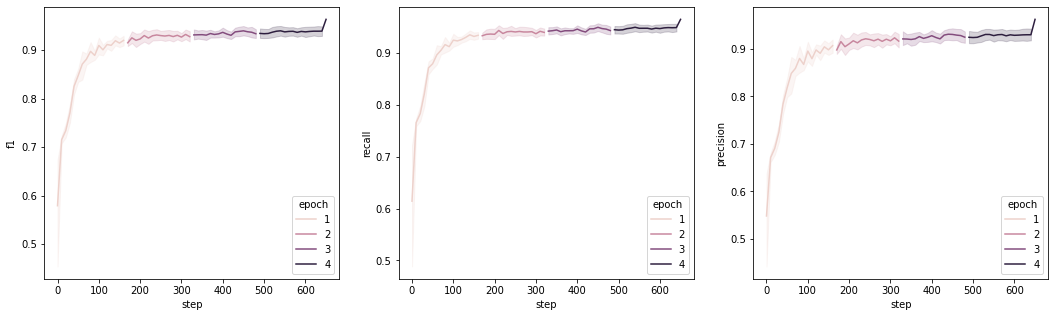

In [260]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))
seaborn.lineplot(data=eval_history, x='step', y='f1', hue='epoch', ax=ax[0])
seaborn.lineplot(data=eval_history, x='step', y='recall', hue='epoch', ax=ax[1])
seaborn.lineplot(data=eval_history, x='step', y='precision', hue='epoch', ax=ax[2])

In [269]:
# micro-averaged scores
test_scores.round(2).mean()

fold         4.500
f1           0.938
precision    0.928
recall       0.950
dtype: float64

In [287]:
#['B-NotNegated', 'I-NotNegated'] -> 'NotNegated'
#['B-NotNegated', 'I-NotNegated', 'I-NotNegated'] -> 'NotNegated'
#...
_predlist = [(labmap[t], 'B' if 'B-' in t else 'I') for l in predlist[i]['prediction'] for t in l if len(l)>0]
_truthlist = [(labmap[t], 'B' if 'B-' in t else 'I') for l in predlist[i]['truth'] for t in l if len(l)>0]

tr_c = []
pr_c = []
tr_r = []
pr_r = []

b_truth = []
b_pred = []
for _t,_p in zip(_truthlist, _predlist):
    if _t[1]==_p[1]=='B':
        tr_c.append(_t[0])
        pr_c.append(_p[0])
    tr_r.append(_t[0])
    pr_r.append(_p[0])
    
    b_truth.append(_t[1]=='B')
    b_pred.append(_p[1]=='B')
    
tr_c, pr_c, tr_r, pr_r = np.array(tr_c), np.array(pr_c), np.array(tr_r), np.array(pr_r)
b_truth, b_pred = np.array(b_truth), np.array(b_pred)

TN_c = np.sum((pr_c==tr_c) & (pr_c==False))
TP_c = np.sum((pr_c==tr_c) & (pr_c==True))
FP_c = np.sum((pr_c!=tr_c) & (pr_c==True))
FN_c = np.sum((pr_c!=tr_c) & (pr_c==False))

TN_r = np.sum((pr_r==tr_r) & (pr_r==False))
TP_r = np.sum((pr_r==tr_r) & (pr_r==True))
FP_r = np.sum((pr_r!=tr_r) & (pr_r==True))
FN_r = np.sum((pr_r!=tr_r) & (pr_r==False))

TN_b = np.sum((b_pred==b_truth) & (b_pred==False))
TP_b = np.sum((b_pred==b_truth) & (b_pred==True))
FP_b = np.sum((b_pred!=b_truth) & (b_pred==True))
FN_b = np.sum((b_pred!=b_truth) & (b_pred==False))

print(TN_c, TP_c, FP_c, FN_c)
print(TN_r, TP_r, FP_r, FN_r)
print(TN_b, TP_b, FP_b, FN_b)

327 53 7 3
399 55 8 4
47 390 14 15


In [68]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [277]:
# B-NotNegated, B-Negated
labmap = {'B-NotNegated': False, 'B-Negated': True, 'I-NotNegated': False, 'I-Negated': True}

manual_scores = []
for i in range(len(predlist)):
    # accuracy over all documents, flattened
    predlist[i]['truth'] = [l for l in predlist[i]['truth'] if len(l)>0]
    predlist[i]['prediction'] = [l for l in predlist[i]['prediction'] if len(l)>0]

    pr = np.array([labmap[t] for d in predlist[i]['prediction'] for t in d if labmap[t] is not None], dtype=bool)
    tr = np.array([labmap[t] for d in predlist[i]['truth'] for t in d if labmap[t] is not None], dtype=bool) # if 'I-' not in t

    pr = pr[np.where(~np.isnan(pr))[0]]
    tr = tr[np.where(~np.isnan(tr))[0]]

    TN = np.sum((pr==tr) & (pr==False))
    TP = np.sum((pr==tr) & (pr==True))
    FP = np.sum((pr!=tr) & (pr==True))
    FN = np.sum((pr!=tr) & (pr==False))
    print(TN, TP, FP, FN)

    # micro
    f1 = f1_score(tr, pr, average='micro')
    precision = precision_score(tr, pr, average='micro')
    recall = recall_score(tr, pr, average='micro')
    manual_scores.append({'fold': i, 'focus': 'micro', 'f1': f1, 'precision': precision, 'recall': recall})

    # macro
    f1 = f1_score(tr, pr, average='macro')
    precision = precision_score(tr, pr, average='macro')
    recall = recall_score(tr, pr, average='macro')
    manual_scores.append({'fold': i, 'focus': 'macro', 'f1': f1, 'precision': precision, 'recall': recall})

    # Negated
    f1 = f1_score(tr, pr)
    precision = precision_score(tr, pr)
    recall = recall_score(tr, pr)
    manual_scores.append({'fold': i, 'focus': 'negated', 'f1': f1, 'precision': precision, 'recall': recall})

    # NotNegated
    f1 = f1_score(~tr, ~pr)
    precision = precision_score(~tr, ~pr)
    recall = recall_score(~tr, ~pr)
    manual_scores.append({'fold': i, 'focus': 'notnegated', 'f1': f1, 'precision': precision, 'recall': recall})
    
manual_scores_df = pd.DataFrame(data=manual_scores)

438 55 3 3
418 40 2 4
430 63 3 5
449 47 3 8
434 56 4 6
431 56 5 6
434 60 2 9
449 51 1 12
480 55 2 9
399 55 8 4


In [241]:
manual_scores_df.groupby('focus').mean()

,fold,f1,precision,recall
focus,,,,
macro,4.5,0.952210,0.964284,0.941958
micro,4.5,0.980227,0.980227,0.980227
negated,4.5,0.915636,0.943301,0.891550
notnegated,4.5,0.988784,0.985268,0.992365


In [292]:
Texts['DL1174']

'Anamnese : Name # heeft sedert drie jaar niet progressieve pijnklachten ter hoogte van de rechter knie , zonder voorafgaand trauma . Geen atrofie of hydrops . 03 - 01 - 1996 : Geen ossale afwijkingen , met name geen aanwijzingen voor een osteochondritis dissecans . Conclusie : Lang bestaande knieklachten rechts op basis van retropatellaire chondropathie rechts .'